# ● Navigation/Mount/Env

In [0]:
# Verify GPU Integration
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('Alert: GPU Device Not Found!')

In [0]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Project Folder
%cd "gdrive/My Drive/skin-lesion-analysis/train01/"                              

/content/gdrive/My Drive/skin-lesion-analysis/train01


In [0]:
# Navigation
%cd ../..

/content/gdrive/My Drive


In [0]:
# Current Directory
%ls

# ● Preamble

## Dataset

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib import colors
import os
import inspect
from tqdm import tqdm
from skimage import io
from skimage import transform
from sklearn.model_selection import train_test_split
import pandas as pd
import sys

import tensorflow
from keras import layers
from keras import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.inception_v3 import InceptionV3


# PATHS
def mkdir_if_not_exist(dir_list):
    for directory in dir_list:
        if not os.path.exists(directory):
            os.makedirs(directory)

root_dir = '/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/'
model_data_dir = os.path.join(root_dir, 'model_data')
submission_dir = os.path.join(root_dir, 'submissions')
task12_test_img_dir = os.path.join(root_dir, 'datasets/ISIC2018/data/ISIC2018_Task1-2_Test_Input')

dir_to_make = [model_data_dir, submission_dir]
mkdir_if_not_exist(dir_list=dir_to_make)
mkdir_if_not_exist(dir_list=dir_to_make)


# DATASETS
# Task 2 Classes
task2_labels = ['globules',
                'milia_like_cyst',
                'negative_network',
                'pigment_network',
                'streaks.png']

ATTRIBUTE_GLOBULES = 1
ATTRIBUTE_MILIA_LIKE_CYST = 2
ATTRIBUTE_NEGATIVE_NETWORK = 3
ATTRIBUTE_PIGMENT_NETWORK = 4
ATTRIBUTE_STREAKS = 5

# Task 3 Classes
MEL   = 0  # Melanoma
NV    = 1  # Melanocytic Nevus
BCC   = 2  # Basal Cell Carcinoma
AKIEC = 3  # Actinic Keratosis/Bowen's Disease (Intraepithelial Carcinoma)
BKL   = 4  # Benign Keratosis (Solar Lentigo/Seborrheic Keratosis/Lichen Planus-Like Keratosis)
DF    = 5  # Dermatofibroma
VASC  = 6  # Vascular Lesion
classes = [MEL, NV, BCC, AKIEC, BKL, DF, VASC]
class_names = ['MEL','NV','BCC','AKIEC','BKL','DF','VASC']




# TASK 1: PREDICTION
task12_test_image_ids = list()
if os.path.isdir(task12_test_img_dir):
    task12_test_image_ids = [fname.rsplit('.', maxsplit=1)[0] for fname in os.listdir(task12_test_img_dir)
                                   if fname.startswith('ISIC') and fname.lower().endswith('.jpg')]
task12_test_image_ids.sort()





def load_images(image_ids, from_dir, output_size=None, fname_fn=None, verbose=True, return_size=False):
    images = []
    if verbose:
        print('loading images from', from_dir)
    if return_size:
        image_sizes = []
        for image_id in tqdm(image_ids):
            image, image_size = load_image_by_id(image_id,
                                                 from_dir=from_dir,
                                                 output_size=output_size,
                                                 fname_fn=fname_fn,
                                                 return_size=True)
            images.append(image)
            image_sizes.append(image_size)
        return images, image_sizes
    else:
        for image_id in tqdm(image_ids):
            image = load_image_by_id(image_id,
                                     from_dir=from_dir,
                                     output_size=output_size,
                                     fname_fn=fname_fn)
            images.append(image)
        return images
            
    
    
    
        
# Color Augmentation Data      
def load_task12_colorAug_images(version=None, output_size=None):  
    dataset = '/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/colorAug/task12_colorAug' + version + '_%d.npy' % (output_size)
    images = np.load(dataset)
    return images 
   
    
# Primary Training Set      
def load_task12_training_images(output_size=None):
  if output_size==224:
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task12_images_224.npy')
  if output_size==512:
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task12_images_512.npy')
  return images
  
def load_task1_training_masks(output_size=None):
  if output_size==224:
    masks = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task1_masks_224.npy')
  if output_size==512:
    masks = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task1_masks_512.npy')
  return masks  
  
def load_task12_test_images(output_size=None):
  if output_size==224: 
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task12_test_images_224.npy')
  if output_size==512:
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task12_test_images_512.npy')
  image_sizes = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task12_test_images_sizes.npy')
  return images, image_sizes 
  
  
  
def load_task12_validation_images(output_size=None):
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task12_validation_images_224.npy')
    image_sizes = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task12_validation_images_sizes.npy')
    return images, image_sizes
  
def load_task3_training_images(output_size=None):
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task3_images_224.npy')
    return images
  
def load_task3_validation_images(output_size=None):
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task3_validation_images_224.npy')
    return images
  
def load_task3_test_images(output_size=None):
    images = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task3_test_images_224.npy')
    return images
  
def load_task2_training_masks(output_size=None):
    masks = np.load('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/task2_masks_224.npy')
    bg_masks = masks.max() - masks.max(axis=-1)
    bg_masks = bg_masks[..., None]
    masks = np.concatenate([bg_masks, masks], axis=-1)
    return masks
  
def load_task3_training_labels():
    labels = []
    with open('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv','r') as f:
        for i, line in tqdm(enumerate(f.readlines()[1:])):
            fields = line.strip().split(',')
            labels.append([eval(field) for field in fields[1:]])
        labels = np.stack(labels, axis=0)
    return labels

def partition_task3_data(x, y, k=5, i=0, test_split=1. / 6, seed=42):
    assert isinstance(k, int) and isinstance(i, int) and 0 <= i < k
    fname = '/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_LesionGroupings.csv'
    assert os.path.exists(fname)
    df = pd.read_csv('/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/data/ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_LesionGroupings.csv')
    grouped = df.groupby('lesion_id', sort=True)
    lesion_ids = []
    for name, group in grouped:
        image_ids = group.image.tolist()
        lesion_ids.append([name, image_ids])
    np.random.seed(seed)
    n = len(lesion_ids)
    indices = np.random.permutation(n)
    image_ids = [image_id for idx in indices for image_id in lesion_ids[idx][1]]
    n = len(image_ids)
    n_set = int(n * (1. - test_split)) // k
    indices = [i for i in range(k) for _ in range(n_set)] + [-1] * (n - n_set * k)
    indices = list(zip(indices, image_ids))
    indices.sort(key=lambda x: x[1])
    indices = np.array([idx for idx, image_id in indices], dtype=np.uint)
    valid_indices = (indices == i)
    test_indices = (indices == -1)
    train_indices = ~(valid_indices | test_indices)
    x_valid = x[valid_indices]
    y_valid = y[valid_indices]
    x_train = x[train_indices]
    y_train = y[train_indices]
    x_test = x[test_indices]
    y_test = y[test_indices]
    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test)
  
def load_training_data(task_idx, output_size=None, num_partitions=5, idx_partition=0, test_split=0.):
    assert isinstance(task_idx, int) and 0 < task_idx <= 3
    if task_idx == 1:
        x = load_task12_training_images(output_size=output_size)
        y = load_task1_training_masks(output_size=output_size)
        return partition_data(x=x, y=y, k=num_partitions, i=idx_partition, test_split=test_split)
    elif task_idx == 2:
        x = load_task12_training_images(output_size=output_size)
        y = load_task2_training_masks(output_size=output_size)
        return partition_data(x=x, y=y, k=num_partitions, i=idx_partition, test_split=test_split)
    else:
        x = load_task3_training_images(output_size=output_size)
        y = load_task3_training_labels()
        return partition_task3_data(x=x, y=y, k=num_partitions, i=idx_partition, test_split=test_split)
      
def load_validation_data(task_idx, output_size=None):
    assert isinstance(task_idx, int) and 0 < task_idx <= 3
    if task_idx == 1 or task_idx == 2:
        images, image_sizes = load_task12_validation_images(output_size=output_size)
        return images, task12_validation_image_ids, image_sizes
    else:
        return load_task3_validation_images(output_size=output_size), task3_validation_image_ids
      
def load_test_data(task_idx, output_size=None):
    assert isinstance(task_idx, int) and 0 < task_idx <= 3
    if task_idx == 1 or task_idx == 2:
        images, image_sizes = load_task12_test_images(output_size=output_size)
        return images, task12_test_image_ids, image_sizes
    else:
        return load_task3_test_images(output_size=output_size), task3_test_image_ids
      
def partition_data(x, y, k=5, i=0, test_split=1. / 6, seed=42):
    assert isinstance(k, int) and isinstance(i, int) and 0 <= i < k
    n = x.shape[0]
    n_set = int(n * (1. - test_split)) // k
    indices = np.array([i for i in range(k) for _ in range(n_set)] +
                       [-1] * (n - n_set * k),
                       dtype=np.int8)
    np.random.seed(seed)
    np.random.shuffle(indices)
    valid_indices = (indices == i)
    test_indices = (indices == -1)
    train_indices = ~(valid_indices | test_indices)
    x_valid = x[valid_indices]
    y_valid = y[valid_indices]
    x_train = x[train_indices]
    y_train = y[train_indices]
    x_test = x[test_indices]
    y_test = y[test_indices]
    return (x_train, y_train), (x_valid, y_valid), (x_test, y_test)


Using TensorFlow backend.


## Utilities

In [0]:
import numpy as np
import random
import keras
import os
import errno
import sys
import logging
from keras.models import load_model, model_from_json
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.utils import compute_class_weight as sk_compute_class_weight


# EVAL_UTILS
def get_confusion_matrix(y_true, y_pred, norm_cm=True, print_cm=True):
    true_class = np.argmax(y_true, axis=1)
    pred_class = np.argmax(y_pred, axis=1)
    cnf_mat = confusion_matrix(true_class, pred_class, labels=classes)
    total_cnf_mat = np.zeros(shape=(cnf_mat.shape[0] + 1, cnf_mat.shape[1] + 1), dtype=np.float)
    total_cnf_mat[0:cnf_mat.shape[0], 0:cnf_mat.shape[1]] = cnf_mat
    for i_row in range(cnf_mat.shape[0]):
        total_cnf_mat[i_row, -1] = np.sum(total_cnf_mat[i_row, 0:-1])
    for i_col in range(cnf_mat.shape[1]):
        total_cnf_mat[-1, i_col] = np.sum(total_cnf_mat[0:-1, i_col])
    if norm_cm:
        cnf_mat = cnf_mat/(cnf_mat.astype(np.float).sum(axis=1)[:, np.newaxis] + 0.001)
    total_cnf_mat[0:cnf_mat.shape[0], 0:cnf_mat.shape[1]] = cnf_mat
    if print_cm:
        print_confusion_matrix(cm=total_cnf_mat, labels=class_names + ['TOTAL', ])
    return cnf_mat

def get_precision_recall(y_true, y_pred, print_pr=True):
    true_class = np.argmax(y_true, axis=1)
    pred_class = np.argmax(y_pred, axis=1)
    precision, recall, _, _ = precision_recall_fscore_support(y_true=true_class,
                                                              y_pred=pred_class,
                                                              labels=classes,
                                                              warn_for=())
    if print_pr:
        print_precision_recall(precision=precision, recall=recall, labels=class_names)
    return precision, recall

def compute_class_weights(y, wt_type='balanced', return_dict=True):
    if len(y.shape) > 1:
        y = y.argmax(axis=-1)
    assert wt_type in ['ones', 'balanced', 'balanced-sqrt'], 'Weight type not supported'
    classes = np.unique(y)
    class_weights = np.ones(shape=classes.shape[0])
    if wt_type == 'balanced' or wt_type == 'balanced-sqrt':
        class_weights = sk_compute_class_weight(class_weight='balanced',
                                                classes=classes,
                                                y=y)
        if wt_type == 'balanced-sqrt':
            class_weights = np.sqrt(class_weights)
    if return_dict:
        class_weights = dict([(i, w) for i, w in enumerate(class_weights)])
    return class_weights

def jaccard(y_true, y_pred):
    intersect = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred)
    return (float(intersect))/(union - intersect +  1e-7)

def compute_jaccard(y_true, y_pred):
    mean_jaccard = 0.
    thresholded_jaccard = 0.
    for im_index in range(y_pred.shape[0]):
        current_jaccard = jaccard(y_true=y_true[im_index], y_pred=y_pred[im_index])
        mean_jaccard += current_jaccard
        thresholded_jaccard += 0 if current_jaccard < 0.65 else current_jaccard
    mean_jaccard = mean_jaccard/y_pred.shape[0]
    thresholded_jaccard = thresholded_jaccard/y_pred.shape[0]
    return mean_jaccard, thresholded_jaccard


# FILENAME_UTILS
def get_run_dir(run_name):
    dirname = os.path.join(model_data_dir, run_name)
    try:
        os.makedirs(dirname)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    return dirname

def get_weights_filename(run_name):
    dirname = get_run_dir(run_name)
    weights_filename = os.path.join(dirname, '%s.hdf5' % run_name)
    return weights_filename

def get_csv_filename(run_name):
    dirname = get_run_dir(run_name)
    csv_filename = os.path.join(dirname, '%s.csv' % run_name)
    return csv_filename

def get_log_filename(run_name):
    dirname = get_run_dir(run_name)
    log_filename = os.path.join(dirname, '%s_log.txt' % run_name)
    return log_filename

def get_model_summary_filename(run_name):
    dirname = get_run_dir(run_name)
    filename = os.path.join(dirname, '%s.txt' % run_name)
    return filename

def get_model_image_filename(run_name):
    dirname = get_run_dir(run_name)
    filename = os.path.join(dirname, '%s.png' % run_name)
    return filename

def get_json_filename(run_name):
    dirname = get_run_dir(run_name)
    json_filename = os.path.join(dirname, '%s.json' % run_name)
    return json_filename

def get_model_config_filename(run_name):
    dirname = get_run_dir(run_name)
    config_filename = os.path.join(dirname, '%s.pkl' % run_name)
    return config_filename


# MODEL_UTILS
def load_model_weights_from(model, weights, skip_mismatch):
    if weights is None:
        return
    if os.path.exists(weights):
        model.load_weights(weights, by_name=True, skip_mismatch=skip_mismatch)
        return
    weights_path = get_weights_filename(weights)
    if os.path.exists(weights_path):
        model.load_weights(weights_path, by_name=True, skip_mismatch=skip_mismatch)
        return
    raise ValueError('Unknown weights to load from!', weights, weights_path)

def save_model_to_run(model, run_name):
    h5_path = get_weights_filename(run_name)
    model.save_weights(h5_path)


def load_model_from_run(backbone_name,
                        load_model_from,
                        load_weights_from=None,
                        skip_mismatch=True):
    b = backbone(backbone_name)
    json_path = get_json_filename(load_model_from)
    if not os.path.exists(json_path):
        h5_path = get_weights_filename(load_model_from)
        if not os.path.exists(h5_path):
            raise ValueError("run with name %s doesn't exist" % load_model_from)
        model = load_model(h5_path, custom_objects=b.custom_objects, compile=False)
    else:
        with open(json_path, 'r') as json_file:
            json_string = json_file.read()
        model = model_from_json(json_string, custom_objects=b.custom_objects)
        if load_weights_from:
            h5_path = get_weights_filename(load_weights_from)
            if os.path.exists(h5_path):
                model.load_weights(h5_path, by_name=True, skip_mismatch=skip_mismatch)
    return model

def freeze_model(model, layers=None):
    if layers is None:
        model.trainable = False
    else:
        for layer in layers:
            if isinstance(layer, int):
                layer = model.get_layer(index=layer)
            elif isinstance(layer, str):
                layer = model.get_layer(name=layer)
            else:
                raise ValueError('layer must be either an index or a string')
            layer.trainable = False
    return model


def draw_model(save_to_dir, model, name):
    filename = os.path.join(model_data_dir, save_to_dir, '%s.png' % name)
    keras.utils.plot_model(model,
                           to_file=filename,
                           show_shapes=True,
                           show_layer_names=True)

def name_or_none(prefix, name):
    return prefix + name if (prefix is not None and name is not None) else None


# PREDICTION_UTILS
def inv_sigmoid(x):
    x = np.clip(x, eps, 1 - eps)
    return np.log(x / (1. - x))

eps = np.finfo(np.float32).eps

def sigmoid(x):
    return 1. / (1. + np.exp(-x))

def rot90_4D(images):
    return np.transpose(np.flip(images, axis=2), axes=[0, 2, 1, 3])

def rot180_4D(images):
    return np.flip(np.flip(images, axis=1), axis=2)

def rot270_4D(images):
    return np.flip(np.transpose(images, axes=[0, 2, 1, 3]), axis=2)

def fliplr_4D(images):
    return np.flip(images, axis=2)

def flipud_4D(images):
    return np.flip(images, axis=1)

def cyclic_pooling(y,
                   y_rot90,
                   y_rot180,
                   y_rot270,
                   y_fliplr=None,
                   y_rot90_fliplr=None,
                   y_rot180_fliplr=None,
                   y_rot270_fliplr=None,
                   use_sigmoid=True,
                   data_type='img'):
    if len(y.shape) == 3:
        data_type = 'mask'
        y = y[..., None]
        y_rot90 = y_rot90[..., None]
        y_rot180 = y_rot180[..., None]
        y_rot270 = y_rot270[..., None]
        y_fliplr = y_fliplr[..., None]
        y_rot90_fliplr = y_rot90_fliplr[..., None]
        y_rot180_fliplr = y_rot180_fliplr[..., None]
        y_rot270_fliplr = y_rot270_fliplr[..., None]
    y1 = rot270_4D(y_rot90)
    y2 = rot180_4D(y_rot180)
    y3 = rot90_4D(y_rot270)
    y4 = fliplr_4D(y_fliplr)
    y5 = rot270_4D(fliplr_4D(y_rot90_fliplr))
    y6 = rot180_4D(fliplr_4D(y_rot180_fliplr))
    y7 = rot90_4D(fliplr_4D(y_rot270_fliplr))
    y_stacked = np.stack([y, y1, y2, y3, y4, y5, y6, y7], axis=0)
    if use_sigmoid:
        y_stacked = inv_sigmoid(y_stacked)
    y_stacked = np.mean(y_stacked, axis=0, keepdims=False)
    y_stacked = sigmoid(y_stacked)
    if data_type == 'mask':
        y_stacked = y_stacked[..., 0]
    return y_stacked

def cyclic_stacking(x):
    assert len(x.shape) == 4
    x_rot90 = rot90_4D(x)
    x_rot180 = rot180_4D(x)
    x_rot270 = rot270_4D(x)
    x_fliplr = fliplr_4D(x)
    x_rot90_fliplr = fliplr_4D(x_rot90)
    x_rot180_fliplr = fliplr_4D(x_rot180)
    x_rot270_fliplr = fliplr_4D(x_rot270)
    return x, x_rot90, x_rot180, x_rot270, x_fliplr, x_rot90_fliplr, x_rot180_fliplr, x_rot270_fliplr


# PRINT_UTILS
class PrintColors:
    GREEN = "\033[0;32m"
    BLUE = "\033[1;34m"
    RED = "\033[1;31m"
    HEADER = '\033[95m'
    OK_BLUE = '\033[94m'
    OK_GREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    END_COLOR = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def on_aws():
    if 'ubuntu' in root_dir:
        return True
    return False

def log_variable(var_name, var_value):
    print('{: <20} : {}'.format(var_name, var_value))

def print_confusion_matrix(cm, labels):
    columnwidth = max([len(x) for x in labels] + [12])
    print()
    first_cell = "True\Pred"
    print("|%{0}s|".format(columnwidth - 2) % first_cell, end="")
    for label in labels:
        print("%{0}s|".format(columnwidth -1) % label, end="")
    print()
    first_cell = "-------"
    print("|%{0}s|".format(columnwidth-2) % first_cell, end="")
    for _ in labels:
        print("%{0}s|".format(columnwidth-1) % first_cell, end="")
    print()
    for i, label1 in enumerate(labels):
        print("|%{0}s|".format(columnwidth - 2) % label1, end="")
        for j in range(len(labels)):
            cell = "%{0}.2f|".format(columnwidth-1) % cm[i, j]
            if i == len(labels) - 1 or j == len(labels) - 1:
                cell = "%{0}d|".format(columnwidth-1) % cm[i, j]
                if i == j:
                    print("%{0}s|".format(columnwidth-1) % ' ', end="")
                else:
                    print(PrintColors.BLUE + cell + PrintColors.END_COLOR, end="")
            elif i == j:
                print(PrintColors.GREEN + cell + PrintColors.END_COLOR, end="")
            else:
                print(PrintColors.RED + cell + PrintColors.END_COLOR, end="")
        print()

def print_precision_recall(precision, recall, labels):
    columnwidth = max([len(x) for x in labels] + [12])
    print()
    first_cell = " "
    print("|%{0}s|".format(columnwidth-2) % first_cell, end="")
    for label in labels:
        print("%{0}s|".format(columnwidth-1) % label, end="")
    print("%{0}s|".format(columnwidth-1) % 'MEAN', end="")
    print()
    first_cell = "-------"
    print("|%{0}s|".format(columnwidth-2) % first_cell, end="")
    for _ in labels:
        print("%{0}s|".format(columnwidth-1) % first_cell, end="")
    print("%{0}s|".format(columnwidth-1) % first_cell, end="")
    print()
    print("|%{0}s|".format(columnwidth-2) % 'precision', end="")
    for j in range(len(labels)):
        cell = "%{0}.3f|".format(columnwidth-1) % precision[j]
        print(PrintColors.GREEN + cell + PrintColors.END_COLOR, end="")

    cell = "%{0}.3f|".format(columnwidth-1) % np.mean(precision)
    print(PrintColors.BLUE + cell + PrintColors.END_COLOR, end="")
    print()
    print("|%{0}s|".format(columnwidth-2) % 'recall', end="")
    for j in range(len(labels)):
        cell = "%{0}.3f|".format(columnwidth-1) % recall[j]
        print(PrintColors.GREEN + cell + PrintColors.END_COLOR, end="")
    cell = "%{0}.3f|".format(columnwidth-1) % np.mean(recall)
    print(PrintColors.BLUE + cell + PrintColors.END_COLOR, end="")
    print('')

class Tee(object):
    def __init__(self, stream1, stream2):
        self.stream1 = stream1
        self.stream2 = stream2
        self.__missing_method_name = None
    def __getattribute__(self, name):
        return object.__getattribute__(self, name)
    def __getattr__(self, name):
        self.__missing_method_name = name
        return getattr(self, '__methodmissing__')
    def __methodmissing__(self, *args, **kwargs):
        callable2 = getattr(self.stream2, self.__missing_method_name)
        callable2(*args, **kwargs)
        callable1 = getattr(self.stream1, self.__missing_method_name)
        return callable1(*args, **kwargs)


# VISUALIZATION_UTILS
def plot_mask(axis_in, img_in, mask_in, title_in):
    mask_colors = ['yellow', 'darkslateblue', 'lightskyblue', 'dodgerblue', 'navy', 'navy', 'navy']
    img = img_in.copy()
    axis_in.clear()
    if mask_in.shape[2] > 1:
        mask_max = np.argmax(mask_in, axis=2)
        for mask_idx in range(1, mask_in.shape[2]):
            img[mask_max == mask_idx, :] = np.round(np.asarray(colors.colorConverter.to_rgb(mask_colors[0])) * 255)
    else:
        img[mask_in[:, :, 0] > 0.5, :] = np.round(np.asarray(colors.colorConverter.to_rgb('yellow')) * 255)
    axis_in.imshow(img)
    font_weight = 'bold'
    font_color = 'k'
    fontdict = {'family': 'raleway',
                'color': font_color,
                'weight': font_weight,
                'size': 10,
    
                }
    axis_in.set_title(title_in,fontdict=fontdict)

class BatchVisualization(object):
    def __init__(self, images,
        true_masks=None, pred_masks=None,
        true_labels=None, pred_labels=None,
        legends=None, **fig_kwargs):
        self.images = images
        self.n_images = self.images.shape[0]
        self.true_masks = true_masks
        self.pred_masks = pred_masks
        self.true_labels = true_labels
        self.pred_labels = pred_labels
        self.legends = legends
        if true_labels is not None:
            self.ncols = fig_kwargs.get('ncols', 3)
            self.nrows = fig_kwargs.get('nrows', 3)
        else:
            self.ncols = fig_kwargs.get('ncols', 1)
            self.nrows = fig_kwargs.get('nrows', 3)
        self.batch_size = self.ncols * self.nrows
        self.start_idx = 0
        self.num_plots_per_image = 1
        if self.true_masks is not None:
            self.num_plots_per_image += 1
        if self.pred_masks is not None:
            self.num_plots_per_image += 1
        if self.true_masks is not None and len(self.true_masks.shape) == 3:
            self.true_masks = np.expand_dims(self.true_masks, axis=3)
        if self.pred_masks is not None and len(self.pred_masks.shape) == 3:
            self.pred_masks = np.expand_dims(self.pred_masks, axis=3)
        self.mask_type = fig_kwargs.get('mask_type', 'contour')

    
    def __call__(self, *args, **kwargs):
        self.fig, self.ax = plt.subplots(figsize=(7.5, 7),
                                         nrows=self.nrows,
                                         ncols=self.num_plots_per_image * self.ncols,
                                         sharex='all',
                                         sharey='all',
                                         gridspec_kw={'hspace': 0.3,
                                                      'wspace': 0.
                                                      }
                                         )
        self.ax = np.ravel(self.ax)
        for ax in self.ax:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            ax.axis('off')
        self.fig.subplots_adjust(top=0.95, bottom=0.08, hspace=0, wspace=0)
        self.axprev = plt.axes([0.39, 0.02, 0.12, 0.04])
        self.axnext = plt.axes([0.55, 0.02, 0.12, 0.04])
        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.next)
        self.bprev = Button(self.axprev, 'Previous')
        self.bprev.on_clicked(self.prev)
        self.start_idx = 0
        self.update_batch()
        self.update_buttons()
        plt.show(block=True)

    def next(self, event):
        self.start_idx += self.batch_size
        self.update_batch()
        self.update_buttons()
        plt.show(block=True)

    def prev(self, event):
        self.start_idx -= self.batch_size
        self.update_batch()
        self.update_buttons()
        plt.show(block=True)

    def update_buttons(self):
        if self.start_idx + self.batch_size < self.n_images:
            self.axnext.set_visible(True)
            self.bnext.set_active(True)
        else:
            self.axnext.set_visible(False)
            self.bnext.set_active(False)

        if self.start_idx - self.batch_size >= 0:
            self.bprev.set_active(True)
            self.axprev.set_visible(True)
        else:
            self.bprev.set_active(False)
            self.axprev.set_visible(False)

    def update_batch(self):
        for ax_idx, image_idx in enumerate(range(self.start_idx,
                                                 min(self.start_idx + self.batch_size,
                                                     self.n_images))):
            img_ax_idx = ax_idx * self.num_plots_per_image
            self.ax[img_ax_idx].clear()
            self.ax[img_ax_idx].imshow(self.images[image_idx])
            if self.true_masks is not None:
                img_ax_idx += 1
                plot_mask(axis_in=self.ax[img_ax_idx],
                          img_in=self.images[image_idx],
                          mask_in=self.true_masks[image_idx],
                          title_in='Ground Truth')
            if self.true_labels is not None or self.pred_labels is not None:
                true_label = None if self.true_labels is None else class_names[np.argmax(self.true_labels[image_idx])]
                pred_label = None if self.pred_labels is None else class_names[np.argmax(self.pred_labels[image_idx])]
                if true_label is not None and pred_label is not None:
                    label = 'GT:%s; Y_Hat:%s' % (true_label, pred_label)
                    font_color = 'darkgreen' if true_label == pred_label else 'darkred'
                else:
                    label = '%s' % true_label if pred_label is None else pred_label
                    font_color = 'k'
                font_weight = 'bold'
                fontdict = {'family': 'raleway',
                            'color': font_color,
                            'weight': font_weight,
                            'size': 10,
                            }
                ax = self.ax[img_ax_idx]
                ax.set_title(label,fontdict=fontdict)
            if self.pred_masks is not None:
                img_ax_idx += 1
                plot_mask(axis_in=self.ax[img_ax_idx],
                          img_in=self.images[image_idx],
                          mask_in=self.pred_masks[image_idx],
                          title_in='Predicted Mask')
        if self.legends:
            plt.figlegend()
        for ax in self.ax:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            ax.axis('off')
        plt.draw()

def view_by_batch(images, masks=None):
    batch_visualization = BatchVisualization(images, masks)
    batch_visualization()


## Prime

In [0]:
import math
import keras
import numpy as np
from matplotlib import pyplot as plt
from plotly import __version__
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.utils.vis_utils import plot_model
from keras import backend as K

# CALLBACK
plt.ion()

class ValidationPrediction(Callback):
    def __init__(self, show_confusion_matrix=False, **kwargs):
        super(ValidationPrediction, self).__init__()

        self.show_confusion_matrix = show_confusion_matrix

        self.visualize = kwargs.get('visualize', False)
        self.nrows = kwargs.get('nrows', 5)
        self.ncols = kwargs.get('ncols', 5)
        self.mask_colors = kwargs.get('mask_colors', ['r', 'b', 'g', 'c', 'm', 'y'])
        self.n_choices = self.nrows * self.ncols

        # for display purposes
        self.fig = None
        self.ax = None
        self.indices = None

        self.confusion_fig = None
        self.confusion_ax = None

        # setup
        self.y_true = None
        self.y_pred = None

    def on_epoch_end(self, epoch, logs=None):
        self.make_predictions()
        if self.show_confusion_matrix:
            self.view_confusion_matrix()

        if self.visualize:
            self.visualize_validation_prediction()

    def make_predictions(self):
        self.y_pred = self.model.predict(self.validation_data[0])
        self.y_true = self.validation_data[1]

    def view_confusion_matrix(self):
        _ = get_confusion_matrix(y_true=self.y_true, y_pred=self.y_pred, print_cm=True)
        get_precision_recall(y_true=self.y_true, y_pred=self.y_pred)

    def visualize_validation_prediction(self):
        if self.fig is None:
            self.fig, self.ax = plt.subplots(figsize=(5, 5),
                                             nrows=self.nrows,
                                             ncols=self.ncols,
                                             sharex='all',
                                             sharey='all')

            n_samples = self.validation_data[0].shape[0]

            self.indices = np.random.choice(np.arange(n_samples),
                                            size=self.n_choices,
                                            replace=False)

            x = self.validation_data[0][[self.indices]]

            for i, ax in enumerate(self.ax.flatten()):
                ax.clear()
                ax.imshow(x[i])

            plt.show()

        y_true = self.y_true[self.indices]
        y_pred = self.y_pred[self.indices]

        # check to see if masks, or labels
        try:
            n_imgs, img_height, img_width, img_channel = y_true.shape
            masks = np.concatenate(y_pred, y_true)
            labels = None
        except ValueError:
            n_imgs, n_classes = y_true.shape
            labels = (y_pred, y_true)
            masks = None

        for i, ax in enumerate(self.ax.flatten()):

            if masks is not None:
                if len(masks.shape) == 2:
                    masks = np.expand_dims(masks, axis=2)

                for j in range(masks.shape[2]):
                    mask = masks[:, :, j]
                    if mask.max() > 0:
                        ax.contour(mask, [127.5, ],
                                   colors=self.mask_colors[j])

            if labels is not None:
                y_pred_i = labels[0][i].argmax()
                y_true_i = labels[1][i].argmax()
                ax.set_title('%s/%s' % (y_pred_i, y_true_i))
                if y_pred_i != y_true_i:
                    color = 'red' if y_true_i == 0 else 'magenta'
                else:
                    color = 'green'

                for axis in ['top', 'bottom', 'left', 'right']:
                    ax.spines[axis].set_linewidth(2.0)
                    ax.spines[axis].set_color(color)

            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')

        # plt.subplots_adjust(wspace=0, hspace=0)

        self.fig.canvas.draw()
        self.fig.canvas.flush_events()
        plt.pause(3)
        

def config_seg_callbacks(run_name=None, factor=0.5, patience=2, min_lr=1e-07, mode='auto'):
    callbacks = [
        ValidationPrediction(show_confusion_matrix=False),
        ReduceLROnPlateau(monitor='val_loss',
                          factor=factor,
                          patience=patience,
                          verbose=1,
                          mode=mode,
                          min_lr=min_lr),
    ]
    if run_name:
        callbacks.extend([
            ModelCheckpoint(get_weights_filename(run_name),
                            monitor='val_loss',
                            save_best_only=True,
                            save_weights_only=True,
                            verbose=True),
            CSVLogger(filename=get_csv_filename(run_name))
        ])
    return callbacks


# INITIALIZERS
class PriorProbability(keras.initializers.Initializer):
    def __init__(self, probability=0.01):
        self.probability = probability
    def get_config(self):
        return {
            'probability': self.probability
        }
    def __call__(self, shape, dtype=None):
        result = np.ones(shape, dtype=dtype) * -math.log((1 - self.probability) / self.probability)
        return result


# LOSSES
def focal_loss(alpha=0.25, gamma=2.0, num_classes=1):
    def binary_focal_loss(y_true, y_pred):
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(K.equal(y_true, 1), 1 - y_pred, y_pred)
        focal_weight = alpha_factor * focal_weight ** gamma
        loss = focal_weight * K.binary_crossentropy(y_true, y_pred)
        return loss
    def categorical_focal_loss(y_true, y_pred):
        alpha_factor = K.ones_like(y_true) * alpha
        alpha_factor = tf.where(K.equal(y_true, 1), alpha_factor, 1. - alpha_factor)
        focal_weight = tf.where(K.equal(y_true, 1), 1. - y_pred, y_pred)
        focal_weight = alpha_factor * focal_weight ** gamma
        loss = focal_weight * K.categorical_crossentropy(y_true, y_pred)
        normalizer = K.sum(K.abs(y_true), axis=[1, 2])
        loss = K.sum(loss, axis=[1, 2])/K.maximum(1., normalizer)
        return K.mean(loss)
    if num_classes == 1:
        return binary_focal_loss
    else:
        return categorical_focal_loss


# METRICS
def pixelwise_precision(num_classes=1):
    def binary_pixelwise_precision(y_true, y_pred):
        true_pos = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        total_pos = K.sum(K.abs(y_pred), axis=[1, 2, 3])
        return true_pos / K.clip(total_pos, K.epsilon(), None)
    def categorical_pixelwise_precision(y_true, y_pred):
        true_pos = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
        total_pos = K.sum(K.abs(y_pred), axis=[1, 2])
        return true_pos / K.clip(total_pos, K.epsilon(), None)
    if num_classes == 1:
        return binary_pixelwise_precision
    else:
        return categorical_pixelwise_precision

def pixelwise_recall(num_classes=1):
    return pixelwise_sensitivity(num_classes)

def pixelwise_sensitivity(num_classes=1):
    def binary_pixelwise_sensitivity(y_true, y_pred):
        y_true = K.round(y_true)
        true_pos = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        total_pos = K.sum(K.abs(y_true), axis=[1, 2, 3])
        return true_pos / K.clip(total_pos, K.epsilon(), None)
    def categorical_pixelwise_sensitivity(y_true, y_pred):
        true_pos = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
        total_pos = K.sum(K.abs(y_true), axis=[1, 2])
        return K.mean(true_pos / K.clip(total_pos, K.epsilon(), None), axis=-1)
    if num_classes == 1:
        return binary_pixelwise_sensitivity
    else:
        return categorical_pixelwise_sensitivity

def pixelwise_specificity(num_classes=1):
    def binary_pixelwise_specificity(y_true, y_pred):
        true_neg = K.sum(K.abs((1. - y_true) * (1. - y_pred)), axis=[1, 2, 3])
        total_neg = K.sum(K.abs(1. - y_true), axis=[1, 2, 3])
        return true_neg / K.clip(total_neg, K.epsilon(), None)
    def categorical_pixelwise_specificity(y_true, y_pred):
        y_true, y_pred = y_true[..., 1:], y_pred[..., 1:]
        true_neg = K.sum(K.abs((1. - y_true) * (1. - y_pred)), axis=[1, 2])
        total_neg = K.sum(K.abs(1. - y_true), axis=[1, 2])
        return true_neg / K.clip(total_neg, K.epsilon(), None)
    if num_classes == 1:
        return binary_pixelwise_specificity
    else:
        return categorical_pixelwise_specificity

def dice_coeff(num_classes=1):
    def binary_dice_coeff(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1, 2, 3])
        dice = 2 * intersection / K.clip(union, K.epsilon(), None)
        return dice
    def categorical_dice_coeff(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2])
        union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1, 2])
        dice = 2 * intersection / K.clip(union, K.epsilon(), None)
        return K.mean(dice, axis=-1)
    if num_classes == 1:
        return binary_dice_coeff
    else:
        return categorical_dice_coeff

def class_jaccard_index(idx):
    def jaccard_index(y_true, y_pred):
        y_true, y_pred = y_true[..., idx], y_pred[..., idx]
        y_true = K.round(y_true)
        y_pred = K.round(y_pred)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[0, 1, 2])
        sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[0, 1, 2])
        jac = intersection / K.clip(sum_ - intersection, K.epsilon(), None)
        return jac
    return jaccard_index

def jaccard_index(num_classes):
    def binary_jaccard_index(y_true, y_pred):
        y_true = K.round(y_true)
        y_pred = K.round(y_pred)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
        union = K.sum(K.abs(y_true) + K.abs(y_pred), axis=[1, 2, 3])
        iou = intersection / K.clip(union - intersection, K.epsilon(), None)
        return iou
    def categorical_jaccard_index(y_true, y_pred):
        y_true = K.round(y_true)
        y_pred = K.round(y_pred)
        intersection = K.abs(y_true * y_pred)
        union = K.abs(y_true) + K.abs(y_pred)
        intersection = K.sum(intersection, axis=[0, 1, 2])
        union = K.sum(union, axis=[0, 1, 2])
        iou = intersection / K.clip(union - intersection, K.epsilon(), None)
        return iou
    if num_classes == 1:
        return binary_jaccard_index
    else:
        return categorical_jaccard_index

## Decoder

In [0]:
from keras import Input, backend as K, regularizers
from keras import backend as K
from keras.layers import LeakyReLU
from keras.layers import Conv2D
from keras.layers import Cropping2D
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import UpSampling2D
from keras.layers import Conv2DTranspose
from keras.utils  import conv_utils


# SEGMENTATION
def __conv_block(nb_filters,
                 activation='relu',
                 block_prefix=None):
    options = {
        'kernel_size': 3,
        'strides': 1,
        'padding': 'same',
    }

    nb_layers_per_block = 1 if isinstance(nb_filters, int) else len(nb_filters)
    nb_filters = conv_utils.normalize_tuple(nb_filters, nb_layers_per_block, 'nb_filters')
    def block(x):
        for i, n in enumerate(nb_filters):
            x = Conv2D(filters=nb_filters[i],
                       name=name_or_none(block_prefix, '_conv%d' % (i+1)),
                       **options)(x)
            if activation.lower() == 'leakyrelu':
                x = LeakyReLU(alpha=0.33)(x)
            else:
                x = Activation(activation)(x)
        return x
    return block

def __transition_up_block(nb_filters,
                          merge_size,
                          upsampling_type='deconv',
                          block_prefix=None):
    options = {
        'padding': 'same'
    }
    if upsampling_type not in {'upsample', 'subpixel', 'deconv'}:
        raise ValueError('upsampling_type must be in  {`upsample`, `subpixel`, `deconv`}: %s' % str(upsampling_type))
    merge_size = conv_utils.normalize_tuple(merge_size, 2, 'merge_size')
    def block(ip):
        try:
            src, dst = ip
        except TypeError:
            src = ip
            dst = None
        if K.image_data_format() == 'channels_last':
            indices = slice(1, 3)
            channel_axis = -1
        else:
            indices = slice(2, 4)
            channel_axis = 1
        src_height, src_width = K.get_variable_shape(src)[indices]
        target_height, target_width = merge_size
        scale_factor = ((target_height + src_height - 1) // src_height,
                        (target_width + src_width - 1) // src_width)
        if upsampling_type == 'upsample':
            x = UpSampling2D(size=scale_factor,
                             name=name_or_none(block_prefix, '_upsampling'))(src)
            x = Conv2D(nb_filters, (2, 2),
                       activation='relu', padding='same', name=name_or_none(block_prefix, '_conv'))(x)
        elif upsampling_type == 'subpixel':
            x = Conv2D(nb_filters, (2, 2),
                       activation='relu', padding='same', name=name_or_none(block_prefix, '_conv'))(src)
            x = SubPixelUpscaling(scale_factor=scale_factor,
                                  name=name_or_none(block_prefix, '_subpixel'))(x)
        else:
            x = Conv2DTranspose(nb_filters, (2, 2), strides=scale_factor,
                                name=name_or_none(block_prefix, '_deconv'),
                                **options)(src)
        if src_height * scale_factor[0] > target_height or src_width * scale_factor[1] > target_width:
            height_padding, width_padding = (src_height - target_height) // 2, (src_width - target_width) // 2
            x = Cropping2D(cropping=(height_padding, width_padding),
                           name=name_or_none(block_prefix, 'crop1'))(x)
        if dst is None:
            return x
        dst_height, dst_width = K.get_variable_shape(dst)[indices]
        if dst_height > target_height or dst_width > target_width:
            height_padding, width_padding = ((dst_height - target_height) // 2, (dst_width - target_width) // 2)
            dst = Cropping2D(cropping=(height_padding, width_padding),
                             name=name_or_none(block_prefix, 'crop2'))(dst)
        x = Concatenate(axis=channel_axis, name=name_or_none(block_prefix, '_merge'))([x, dst])
        return x
    return block

def __normalize_target_size(curr_size, target_size, scale_factor):
    while curr_size < target_size:
        target_size //= scale_factor
    return target_size

def default_decoder_model(features,
                          num_classes=1,
                          output_size=224,
                          scale_factor=2,
                          init_nb_filters=64,
                          growth_rate=2,
                          nb_layers_per_block=2,
                          max_nb_filters=512,
                          upsampling_type='deconv',
                          activation='relu',
                          bottleneck=False,
                          use_activation=True,
                          include_top=True):
    output_size = conv_utils.normalize_tuple(output_size, 2, 'output_size')
    output_height, output_width = output_size
    __init_nb_filters = init_nb_filters
    indices = slice(1, 3) if K.image_data_format() == 'channels_last' else slice(2, 4)
    channel = 3 if K.image_data_format() == 'channels_last' else 1
    nb_features = len(features)
    feature_shapes = [K.get_variable_shape(feature) for feature in features]
    feature_sizes = [feature_shape[indices] for feature_shape in feature_shapes]
    feature_height, feature_width = feature_sizes[0]
    if feature_height < output_height or feature_width < output_width:
        __init_nb_filters = int(__init_nb_filters * growth_rate)
    if bottleneck:
        for i in range(nb_features - 1, -1, -1):
            feature_shape = feature_shapes[i]
            nb_filters = int(__init_nb_filters * (growth_rate ** i))
            nb_filters = min(nb_filters, max_nb_filters)
            if feature_shape[channel] > nb_filters:
                features[i] = Conv2D(nb_filters, 1,
                                     padding='same',
                                     activation='relu',
                                     name='feature%d_bottleneck' % (i+1))(features[i])
    nb_layers_per_block = conv_utils.normalize_tuple(nb_layers_per_block, nb_features, 'nb_layers_per_block')
    x = features[-1]
    for i in range(nb_features-1, 0, -1):
        dst = features[i-1]
        dst_height, dst_width = feature_sizes[i-1]
        merge_size = __normalize_target_size(dst_height, output_height, scale_factor)
        if dst_width != dst_height:
            merge_size = (merge_size, __normalize_target_size(dst_width, output_width, scale_factor))
        nb_filters = int(__init_nb_filters * (growth_rate ** (i-1)))
        nb_filters = min(nb_filters, max_nb_filters)
        x = __transition_up_block(nb_filters=nb_filters,
                                  merge_size=merge_size,
                                  block_prefix='feature%d' % (i+1),
                                  upsampling_type=upsampling_type)([x, dst])
        x = __conv_block(nb_filters=conv_utils.normalize_tuple(nb_filters,
                                                               nb_layers_per_block[i-1],
                                                               'nb_filters'),
                         activation=activation,
                         block_prefix='feature%d' % i)(x)
    if __init_nb_filters > init_nb_filters:
        x = __transition_up_block(nb_filters=init_nb_filters,
                                  merge_size=output_size,
                                  block_prefix='decoder_block%d' % (nb_features+1),
                                  upsampling_type=upsampling_type)(x)
        x = __conv_block(nb_filters=[init_nb_filters],
                         activation=activation,
                         block_prefix='feature%d' %(nb_features + 1))(x)
    if include_top:
        x = Conv2D(num_classes, (1, 1), activation='linear', name='predictions')(x)
        if use_activation:
            output_activation = 'sigmoid' if num_classes == 1 else 'softmax'
            x = Activation(output_activation, name='outputs')(x)
    return x


# CLASSIFICATION
def default_classification_model(input_shape=None,
                                 input_tensor=None,
                                 num_classes=7,
                                 num_dense_layers=2,
                                 num_dense_units=256,
                                 dropout_rate=0.,
                                 pooling=None,
                                 use_output_activation=True,
                                 kernel_regularizer=None):
    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    assert kernel_regularizer in [None, 'L1', 'L2', 'L1-L2'], \
        'Unknown regularizer %s' % kernel_regularizer
    if kernel_regularizer == 'L1':
        kernel_regularizer = regularizers.l1(1e-4)
    elif kernel_regularizer == 'L2':
        kernel_regularizer = regularizers.l2(1e-3)
    elif kernel_regularizer == 'L1-L2':
        kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)
    assert pooling in {None, 'avg', 'max', 'flatten'}, 'Unknown pooling option %s' % pooling
    if pooling == 'avg':
        outputs = keras.layers.GlobalAveragePooling2D(name='avg_pool_our')(img_input)
    elif pooling == 'max':
        outputs = keras.layers.GlobalMaxPooling2D(name='max_pool_our')(img_input)
    else:
        outputs = keras.layers.Flatten(name='flatten_our')(img_input)
    if dropout_rate > 0.:
        outputs = keras.layers.Dropout(rate=dropout_rate)(outputs)
    for i in range(num_dense_layers):
        outputs = keras.layers.Dense(num_dense_units,
                                     activation='relu',
                                     name='fc%d' % (i + 1),
                                     kernel_regularizer=kernel_regularizer
                                     )(outputs)

        outputs = keras.layers.Dropout(rate=dropout_rate)(outputs)
    outputs = keras.layers.Dense(num_classes,
                                 name='predictions',
                                 kernel_regularizer=kernel_regularizer
                                 )(outputs)
    if use_output_activation:
        activation = 'sigmoid' if num_classes == 1 else 'softmax'
        outputs = keras.layers.Activation(activation, name='outputs')(outputs)
    return outputs

# ● Color Augmentation

## White Balance/Color Cast

In [0]:
def WhiteBalance(img):
    
    # Extract Color Channels
    img_R = img[:,:,0]
    img_G = img[:,:,1]
    img_B = img[:,:,2]    
    
    # Compute Mean of Each + Overall Channels
    avg_R = np.mean(img_R)
    avg_G = np.mean(img_G)
    avg_B = np.mean(img_B)    
    avg_global = np.mean(img)
    
    # Illumination Profile
    scale_R = (avg_global/avg_R)
    scale_G = (avg_global/avg_G)
    scale_B = (avg_global/avg_B)
    
    # Creating White Balanced Image
    raw_whitebal = np.zeros(img.shape)    
    raw_whitebal[:,:,0] = scale_R * img_R 
    raw_whitebal[:,:,1] = scale_G * img_G 
    raw_whitebal[:,:,2] = scale_B * img_B 

    # Normalization
    max_intensity = np.max(np.max(np.max(raw_whitebal)))
    min_intensity = np.min(np.min(np.min(raw_whitebal)))
    norm_whitebal = (raw_whitebal - min_intensity) / (max_intensity - min_intensity) * 255
    int_whitebal = norm_whitebal.astype(np.uint8)
    
    return int_whitebal


  
def ColorCast(white_img):
  
  # Import Illumination Profiles
  illum = np.genfromtxt('illumination_profiles.csv', delimiter=',')

  # Extract Color Channels
  white_img_R = white_img[:,:,0]
  white_img_G = white_img[:,:,1]
  white_img_B = white_img[:,:,2]

  # Select Random Illumination Profile
  rand = np.random.randint(3)
  illuminant = illum[rand]

  # Apply Illumination Profile
  avg_ill_R = illuminant[0]
  avg_ill_G = illuminant[1]
  avg_ill_B = illuminant[2]    
  avg_ill_all = np.mean(illuminant)
  scale_R = (avg_ill_all/avg_ill_R)
  scale_G = (avg_ill_all/avg_ill_G)
  scale_B = (avg_ill_all/avg_ill_B)

  raw_colorcast = np.zeros(white_img.shape)   
  raw_colorcast[:,:,0] = white_img_R / scale_R
  raw_colorcast[:,:,1] = white_img_G / scale_G
  raw_colorcast[:,:,2] = white_img_B / scale_B

  # Normalization
  max_intensity = np.max(np.max(np.max(raw_colorcast)))
  min_intensity = np.min(np.min(np.min(raw_colorcast)))

  norm_colorcast = (raw_colorcast - min_intensity) / (max_intensity - min_intensity) * 255
  int_colorcast = norm_colorcast.astype(np.uint8)

  return int_colorcast

## HSV/Lab Color Space

In [0]:
import cv2


def convertRGB(all_RGB, color_space):
    
    # Extract Tensor Info
    no_of_images = all_RGB.shape[0]
    x_dim = all_RGB.shape[1]
    y_dim = all_RGB.shape[2]
    no_of_channels = all_RGB.shape[3]
    
    # HSV Space
    if color_space=='hsv' or color_space=='HSV':
        all_HSV = np.zeros( [no_of_images, x_dim, y_dim, no_of_channels], dtype=np.uint8)
        for x in np.arange(0, no_of_images):
            temp_rgb = all_RGB[x,:,:,:]
            temp_hsv = cv2.cvtColor(temp_rgb, cv2.COLOR_BGR2HSV)
            all_HSV[x,:,:,:] = temp_hsv
        return all_HSV
    
    # CIELab Space
    if color_space=='lab' or color_space=='LAB':
        all_LAB = np.zeros( [no_of_images, x_dim, y_dim, no_of_channels], dtype=np.uint8)
        for x in np.arange(0, no_of_images):
            temp_rgb = all_RGB[x,:,:,:]
            temp_lab = cv2.cvtColor(temp_rgb, cv2.COLOR_BGR2Lab)
            all_LAB[x,:,:,:] = temp_lab
        return all_LAB
      
    # Merged Space
    if color_space=='hsv_lab' or color_space=='HSV_LAB':
        HSV_LAB = np.zeros( [no_of_images, x_dim, y_dim, no_of_channels+6], dtype=np.uint8)
        for x in np.arange(0, no_of_images):
            temp_rgb = all_RGB[x,:,:,:]
            temp_hsv = cv2.cvtColor(temp_rgb, cv2.COLOR_BGR2HSV)
            temp_lab = cv2.cvtColor(temp_rgb, cv2.COLOR_BGR2Lab)
            HSV_LAB[x,:,:,:3]  = temp_rgb
            HSV_LAB[x,:,:,3:6] = temp_hsv
            HSV_LAB[x,:,:,6:]  = temp_lab
        return HSV_LAB
      
      


## Custom ImageDataGenerator

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import warnings
from six.moves import range



try:
    import scipy
    # scipy.linalg cannot be accessed until explicitly imported
    from scipy import linalg
    # scipy.ndimage cannot be accessed until explicitly imported
except ImportError:
    scipy = None

from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
from keras_preprocessing.image.directory_iterator import DirectoryIterator
from keras_preprocessing.image.numpy_array_iterator import NumpyArrayIterator
from keras_preprocessing.image.affine_transformations import (apply_affine_transform,
                                                              apply_brightness_shift,
                                                              apply_channel_shift,
                                                              flip_axis)


class CheesecakeImageDataGenerator(object):
    """Generate batches of tensor image data with real-time data augmentation.
     The data will be looped over (in batches).
    # Arguments
        featurewise_center: Boolean.
            Set input mean to 0 over the dataset, feature-wise.
        samplewise_center: Boolean. Set each sample mean to 0.
        featurewise_std_normalization: Boolean.
            Divide inputs by std of the dataset, feature-wise.
        samplewise_std_normalization: Boolean. Divide each input by its std.
        zca_whitening: Boolean. Apply ZCA whitening.
        zca_epsilon: epsilon for ZCA whitening. Default is 1e-6.
        rotation_range: Int. Degree range for random rotations.
        width_shift_range: Float, 1-D array-like or int
            - float: fraction of total width, if < 1, or pixels if >= 1.
            - 1-D array-like: random elements from the array.
            - int: integer number of pixels from interval
                `(-width_shift_range, +width_shift_range)`
            - With `width_shift_range=2` possible values
                are integers `[-1, 0, +1]`,
                same as with `width_shift_range=[-1, 0, +1]`,
                while with `width_shift_range=1.0` possible values are floats
                in the interval [-1.0, +1.0).
        height_shift_range: Float, 1-D array-like or int
            - float: fraction of total height, if < 1, or pixels if >= 1.
            - 1-D array-like: random elements from the array.
            - int: integer number of pixels from interval
                `(-height_shift_range, +height_shift_range)`
            - With `height_shift_range=2` possible values
                are integers `[-1, 0, +1]`,
                same as with `height_shift_range=[-1, 0, +1]`,
                while with `height_shift_range=1.0` possible values are floats
                in the interval [-1.0, +1.0).
        brightness_range: Tuple or list of two floats. Range for picking
            a brightness shift value from.
        shear_range: Float. Shear Intensity
            (Shear angle in counter-clockwise direction in degrees)
        zoom_range: Float or [lower, upper]. Range for random zoom.
            If a float, `[lower, upper] = [1-zoom_range, 1+zoom_range]`.
        channel_shift_range: Float. Range for random channel shifts.
        fill_mode: One of {"constant", "nearest", "reflect" or "wrap"}.
            Default is 'nearest'.
            Points outside the boundaries of the input are filled
            according to the given mode:
            - 'constant': kkkkkkkk|abcd|kkkkkkkk (cval=k)
            - 'nearest':  aaaaaaaa|abcd|dddddddd
            - 'reflect':  abcddcba|abcd|dcbaabcd
            - 'wrap':  abcdabcd|abcd|abcdabcd
        cval: Float or Int.
            Value used for points outside the boundaries
            when `fill_mode = "constant"`.
        horizontal_flip: Boolean. Randomly flip inputs horizontally.
        vertical_flip: Boolean. Randomly flip inputs vertically.
        rescale: rescaling factor. Defaults to None.
            If None or 0, no rescaling is applied,
            otherwise we multiply the data by the value provided
            (after applying all other transformations).
        preprocessing_function: function that will be applied on each input.
            The function will run after the image is resized and augmented.
            The function should take one argument:
            one image (Numpy tensor with rank 3),
            and should output a Numpy tensor with the same shape.
        data_format: Image data format,
            either "channels_first" or "channels_last".
            "channels_last" mode means that the images should have shape
            `(samples, height, width, channels)`,
            "channels_first" mode means that the images should have shape
            `(samples, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
        validation_split: Float. Fraction of images reserved for validation
            (strictly between 0 and 1).
        interpolation_order: int, order to use for
            the spline interpolation. Higher is slower.
        dtype: Dtype to use for the generated arrays.
    # Examples
    Example of using `.flow(x, y)`:
    ```python
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    y_train = np_utils.to_categorical(y_train, num_classes)
    y_test = np_utils.to_categorical(y_test, num_classes)
    datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True)
    # compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied)
    datagen.fit(x_train)
    # fits the model on batches with real-time data augmentation:
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=32),
                        steps_per_epoch=len(x_train) / 32, epochs=epochs)
    # here's a more "manual" example
    for e in range(epochs):
        print('Epoch', e)
        batches = 0
        for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
            model.fit(x_batch, y_batch)
            batches += 1
            if batches >= len(x_train) / 32:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
    ```
    Example of using `.flow_from_directory(directory)`:
    ```python
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
            'data/train',
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
    validation_generator = test_datagen.flow_from_directory(
            'data/validation',
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
    model.fit_generator(
            train_generator,
            steps_per_epoch=2000,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=800)
    ```
    Example of transforming images and masks together.
    ```python
    # we create two instances with the same arguments
    data_gen_args = dict(featurewise_center=True,
                         featurewise_std_normalization=True,
                         rotation_range=90,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         zoom_range=0.2)
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)
    # Provide the same seed and keyword arguments to the fit and flow methods
    seed = 1
    image_datagen.fit(images, augment=True, seed=seed)
    mask_datagen.fit(masks, augment=True, seed=seed)
    image_generator = image_datagen.flow_from_directory(
        'data/images',
        class_mode=None,
        seed=seed)
    mask_generator = mask_datagen.flow_from_directory(
        'data/masks',
        class_mode=None,
        seed=seed)
    # combine generators into one which yields image and masks
    train_generator = zip(image_generator, mask_generator)
    model.fit_generator(
        train_generator,
        steps_per_epoch=2000,
        epochs=50)
    ```
    Example of using ```.flow_from_dataframe(dataframe, directory,
                                            x_col, y_col)```:
    ```python
    train_df = pandas.read_csv("./train.csv")
    valid_df = pandas.read_csv("./valid.csv")
    train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True)
    test_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_dataframe(
            dataframe=train_df,
            directory='data/train',
            x_col="filename",
            y_col="class",
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
    validation_generator = test_datagen.flow_from_dataframe(
            dataframe=valid_df,
            directory='data/validation',
            x_col="filename",
            y_col="class",
            target_size=(150, 150),
            batch_size=32,
            class_mode='binary')
    model.fit_generator(
            train_generator,
            steps_per_epoch=2000,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=800)
    ```
    """

    def __init__(self,
                 colorAugmentation=False,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 brightness_range=None,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format='channels_last',
                 validation_split=0.0,
                 interpolation_order=1,
                 dtype='float32'):

        self.colorAugmentation = colorAugmentation
        self.featurewise_center = featurewise_center
        self.samplewise_center = samplewise_center
        self.featurewise_std_normalization = featurewise_std_normalization
        self.samplewise_std_normalization = samplewise_std_normalization
        self.zca_whitening = zca_whitening
        self.zca_epsilon = zca_epsilon
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.channel_shift_range = channel_shift_range
        self.fill_mode = fill_mode
        self.cval = cval
        self.horizontal_flip = horizontal_flip
        self.vertical_flip = vertical_flip
        self.rescale = rescale
        self.preprocessing_function = preprocessing_function
        self.dtype = dtype
        self.interpolation_order = interpolation_order

        if data_format not in {'channels_last', 'channels_first'}:
            raise ValueError(
                '`data_format` should be `"channels_last"` '
                '(channel after row and column) or '
                '`"channels_first"` (channel before row and column). '
                'Received: %s' % data_format)
        self.data_format = data_format
        if data_format == 'channels_first':
            self.channel_axis = 1
            self.row_axis = 2
            self.col_axis = 3
        if data_format == 'channels_last':
            self.channel_axis = 3
            self.row_axis = 1
            self.col_axis = 2
        if validation_split and not 0 < validation_split < 1:
            raise ValueError(
                '`validation_split` must be strictly between 0 and 1. '
                ' Received: %s' % validation_split)
        self._validation_split = validation_split

        self.mean = None
        self.std = None
        self.principal_components = None

        if np.isscalar(zoom_range):
            self.zoom_range = [1 - zoom_range, 1 + zoom_range]
        elif len(zoom_range) == 2:
            self.zoom_range = [zoom_range[0], zoom_range[1]]
        else:
            raise ValueError('`zoom_range` should be a float or '
                             'a tuple or list of two floats. '
                             'Received: %s' % (zoom_range,))
        if zca_whitening:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, which overrides '
                              'setting of `featurewise_center`.')
            if featurewise_std_normalization:
                self.featurewise_std_normalization = False
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening` '
                              'which overrides setting of'
                              '`featurewise_std_normalization`.')
        if featurewise_std_normalization:
            if not featurewise_center:
                self.featurewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, '
                              'which overrides setting of '
                              '`featurewise_center`.')
        if samplewise_std_normalization:
            if not samplewise_center:
                self.samplewise_center = True
                warnings.warn('This ImageDataGenerator specifies '
                              '`samplewise_std_normalization`, '
                              'which overrides setting of '
                              '`samplewise_center`.')
        if brightness_range is not None:
            if (not isinstance(brightness_range, (tuple, list)) or
                    len(brightness_range) != 2):
                raise ValueError(
                    '`brightness_range should be tuple or list of two floats. '
                    'Received: %s' % (brightness_range,))
        self.brightness_range = brightness_range

    def flow(self,
             x,
             y=None,
             batch_size=32,
             shuffle=True,
             sample_weight=None,
             seed=None,
             save_to_dir=None,
             save_prefix='',
             save_format='png',
             subset=None):
        """Takes data & label arrays, generates batches of augmented data.
        # Arguments
            x: Input data. Numpy array of rank 4 or a tuple.
                If tuple, the first element
                should contain the images and the second element
                another numpy array or a list of numpy arrays
                that gets passed to the output
                without any modifications.
                Can be used to feed the model miscellaneous data
                along with the images.
                In case of grayscale data, the channels axis of the image array
                should have value 1, in case
                of RGB data, it should have value 3, and in case
                of RGBA data, it should have value 4.
            y: Labels.
            batch_size: Int (default: 32).
            shuffle: Boolean (default: True).
            sample_weight: Sample weights.
            seed: Int (default: None).
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: Str (default: `''`).
                Prefix to use for filenames of saved pictures
                (only relevant if `save_to_dir` is set).
            save_format: one of "png", "jpeg"
                (only relevant if `save_to_dir` is set). Default: "png".
            subset: Subset of data (`"training"` or `"validation"`) if
                `validation_split` is set in `ImageDataGenerator`.
        # Returns
            An `Iterator` yielding tuples of `(x, y)`
                where `x` is a numpy array of image data
                (in the case of a single image input) or a list
                of numpy arrays (in the case with
                additional inputs) and `y` is a numpy array
                of corresponding labels. If 'sample_weight' is not None,
                the yielded tuples are of the form `(x, y, sample_weight)`.
                If `y` is None, only the numpy array `x` is returned.
        """
        return NumpyArrayIterator(
            x,
            y,
            self,
            batch_size=batch_size,
            shuffle=shuffle,
            sample_weight=sample_weight,
            seed=seed,
            data_format=self.data_format,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            subset=subset
        )

    def flow_from_directory(self,
                            directory,
                            target_size=(256, 256),
                            color_mode='rgb',
                            classes=None,
                            class_mode='categorical',
                            batch_size=32,
                            shuffle=True,
                            seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):
        """Takes the path to a directory & generates batches of augmented data.
        # Arguments
            directory: string, path to the target directory.
                It should contain one subdirectory per class.
                Any PNG, JPG, BMP, PPM or TIF images
                inside each of the subdirectories directory tree
                will be included in the generator.
                See [this script](
                https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
                for more details.
            target_size: Tuple of integers `(height, width)`,
                default: `(256, 256)`.
                The dimensions to which all images found will be resized.
            color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb".
                Whether the images will be converted to
                have 1, 3, or 4 channels.
            classes: Optional list of class subdirectories
                (e.g. `['dogs', 'cats']`). Default: None.
                If not provided, the list of classes will be automatically
                inferred from the subdirectory names/structure
                under `directory`, where each subdirectory will
                be treated as a different class
                (and the order of the classes, which will map to the label
                indices, will be alphanumeric).
                The dictionary containing the mapping from class names to class
                indices can be obtained via the attribute `class_indices`.
            class_mode: One of "categorical", "binary", "sparse",
                "input", or None. Default: "categorical".
                Determines the type of label arrays that are returned:
                - "categorical" will be 2D one-hot encoded labels,
                - "binary" will be 1D binary labels,
                    "sparse" will be 1D integer labels,
                - "input" will be images identical
                    to input images (mainly used to work with autoencoders).
                - If None, no labels are returned
                  (the generator will only yield batches of image data,
                  which is useful to use with `model.predict_generator()`).
                  Please note that in case of class_mode None,
                  the data still needs to reside in a subdirectory
                  of `directory` for it to work correctly.
            batch_size: Size of the batches of data (default: 32).
            shuffle: Whether to shuffle the data (default: True)
                If set to False, sorts the data in alphanumeric order.
            seed: Optional random seed for shuffling and transformations.
            save_to_dir: None or str (default: None).
                This allows you to optionally specify
                a directory to which to save
                the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: Str. Prefix to use for filenames of saved pictures
                (only relevant if `save_to_dir` is set).
            save_format: One of "png", "jpeg"
                (only relevant if `save_to_dir` is set). Default: "png".
            follow_links: Whether to follow symlinks inside
                class subdirectories (default: False).
            subset: Subset of data (`"training"` or `"validation"`) if
                `validation_split` is set in `ImageDataGenerator`.
            interpolation: Interpolation method used to
                resample the image if the
                target size is different from that of the loaded image.
                Supported methods are `"nearest"`, `"bilinear"`,
                and `"bicubic"`.
                If PIL version 1.1.3 or newer is installed, `"lanczos"` is also
                supported. If PIL version 3.4.0 or newer is installed,
                `"box"` and `"hamming"` are also supported.
                By default, `"nearest"` is used.
        # Returns
            A `DirectoryIterator` yielding tuples of `(x, y)`
                where `x` is a numpy array containing a batch
                of images with shape `(batch_size, *target_size, channels)`
                and `y` is a numpy array of corresponding labels.
        """
        return DirectoryIterator(
            directory,
            self,
            target_size=target_size,
            color_mode=color_mode,
            classes=classes,
            class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links,
            subset=subset,
            interpolation=interpolation
        )

    def flow_from_dataframe(self,
                            dataframe,
                            directory=None,
                            x_col="filename",
                            y_col="class",
                            weight_col=None,
                            target_size=(256, 256),
                            color_mode='rgb',
                            classes=None,
                            class_mode='categorical',
                            batch_size=32,
                            shuffle=True,
                            seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            subset=None,
                            interpolation='nearest',
                            validate_filenames=True,
                            **kwargs):
        """Takes the dataframe and the path to a directory
         and generates batches of augmented/normalized data.
        **A simple tutorial can be found **[here](
                                    http://bit.ly/keras_flow_from_dataframe).
        # Arguments
            dataframe: Pandas dataframe containing the filepaths relative to
                `directory` (or absolute paths if `directory` is None) of the
                images in a string column. It should include other column/s
                depending on the `class_mode`:
                - if `class_mode` is `"categorical"` (default value) it must
                    include the `y_col` column with the class/es of each image.
                    Values in column can be string/list/tuple if a single class
                    or list/tuple if multiple classes.
                - if `class_mode` is `"binary"` or `"sparse"` it must include
                    the given `y_col` column with class values as strings.
                - if `class_mode` is `"raw"` or `"multi_output"` it should contain
                the columns specified in `y_col`.
                - if `class_mode` is `"input"` or `None` no extra column is needed.
            directory: string, path to the directory to read images from. If `None`,
                data in `x_col` column should be absolute paths.
            x_col: string, column in `dataframe` that contains the filenames (or
                absolute paths if `directory` is `None`).
            y_col: string or list, column/s in `dataframe` that has the target data.
            weight_col: string, column in `dataframe` that contains the sample
                weights. Default: `None`.
            target_size: tuple of integers `(height, width)`, default: `(256, 256)`.
                The dimensions to which all images found will be resized.
            color_mode: one of "grayscale", "rgb", "rgba". Default: "rgb".
                Whether the images will be converted to have 1 or 3 color channels.
            classes: optional list of classes (e.g. `['dogs', 'cats']`).
                Default: None. If not provided, the list of classes will be
                automatically inferred from the `y_col`,
                which will map to the label indices, will be alphanumeric).
                The dictionary containing the mapping from class names to class
                indices can be obtained via the attribute `class_indices`.
            class_mode: one of "binary", "categorical", "input", "multi_output",
                "raw", sparse" or None. Default: "categorical".
                Mode for yielding the targets:
                - `"binary"`: 1D numpy array of binary labels,
                - `"categorical"`: 2D numpy array of one-hot encoded labels.
                    Supports multi-label output.
                - `"input"`: images identical to input images (mainly used to
                    work with autoencoders),
                - `"multi_output"`: list with the values of the different columns,
                - `"raw"`: numpy array of values in `y_col` column(s),
                - `"sparse"`: 1D numpy array of integer labels,
                - `None`, no targets are returned (the generator will only yield
                    batches of image data, which is useful to use in
                    `model.predict_generator()`).
            batch_size: size of the batches of data (default: 32).
            shuffle: whether to shuffle the data (default: True)
            seed: optional random seed for shuffling and transformations.
            save_to_dir: None or str (default: None).
                This allows you to optionally specify a directory
                to which to save the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: str. Prefix to use for filenames of saved pictures
                (only relevant if `save_to_dir` is set).
            save_format: one of "png", "jpeg"
                (only relevant if `save_to_dir` is set). Default: "png".
            follow_links: whether to follow symlinks inside class subdirectories
                (default: False).
            subset: Subset of data (`"training"` or `"validation"`) if
                `validation_split` is set in `ImageDataGenerator`.
            interpolation: Interpolation method used to resample the image if the
                target size is different from that of the loaded image.
                Supported methods are `"nearest"`, `"bilinear"`, and `"bicubic"`.
                If PIL version 1.1.3 or newer is installed, `"lanczos"` is also
                supported. If PIL version 3.4.0 or newer is installed, `"box"` and
                `"hamming"` are also supported. By default, `"nearest"` is used.
            validate_filenames: Boolean, whether to validate image filenames in
                `x_col`. If `True`, invalid images will be ignored. Disabling this
                option can lead to speed-up in the execution of this function.
                Default: `True`.
        # Returns
            A `DataFrameIterator` yielding tuples of `(x, y)`
            where `x` is a numpy array containing a batch
            of images with shape `(batch_size, *target_size, channels)`
            and `y` is a numpy array of corresponding labels.
        """
        if 'has_ext' in kwargs:
            warnings.warn('has_ext is deprecated, filenames in the dataframe have '
                          'to match the exact filenames in disk.',
                          DeprecationWarning)
        if 'sort' in kwargs:
            warnings.warn('sort is deprecated, batches will be created in the'
                          'same order than the filenames provided if shuffle'
                          'is set to False.', DeprecationWarning)
        if class_mode == 'other':
            warnings.warn('`class_mode` "other" is deprecated, please use '
                          '`class_mode` "raw".', DeprecationWarning)
            class_mode = 'raw'
        if 'drop_duplicates' in kwargs:
            warnings.warn('drop_duplicates is deprecated, you can drop duplicates '
                          'by using the pandas.DataFrame.drop_duplicates method.',
                          DeprecationWarning)

        return DataFrameIterator(
            dataframe,
            directory,
            self,
            x_col=x_col,
            y_col=y_col,
            weight_col=weight_col,
            target_size=target_size,
            color_mode=color_mode,
            classes=classes,
            class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            subset=subset,
            interpolation=interpolation,
            validate_filenames=validate_filenames
        )

    def standardize(self, x):
        """Applies the normalization configuration in-place to a batch of inputs.
        `x` is changed in-place since the function is mainly used internally
        to standarize images and feed them to your network. If a copy of `x`
        would be created instead it would have a significant performance cost.
        If you want to apply this method without changing the input in-place
        you can call the method creating a copy before:
        standarize(np.copy(x))
        # Arguments
            x: Batch of inputs to be normalized.
        # Returns
            The inputs, normalized.
        """
        if self.preprocessing_function:
            x = self.preprocessing_function(x)
        if self.rescale:
            x *= self.rescale
        if self.samplewise_center:
            x -= np.mean(x, keepdims=True)
        if self.samplewise_std_normalization:
            x /= (np.std(x, keepdims=True) + 1e-6)

        if self.featurewise_center:
            if self.mean is not None:
                x -= self.mean
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_center`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.featurewise_std_normalization:
            if self.std is not None:
                x /= (self.std + 1e-6)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`featurewise_std_normalization`, '
                              'but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        if self.zca_whitening:
            if self.principal_components is not None:
                flatx = np.reshape(x, (-1, np.prod(x.shape[-3:])))
                whitex = np.dot(flatx, self.principal_components)
                x = np.reshape(whitex, x.shape)
            else:
                warnings.warn('This ImageDataGenerator specifies '
                              '`zca_whitening`, but it hasn\'t '
                              'been fit on any training data. Fit it '
                              'first by calling `.fit(numpy_data)`.')
        return x

    def get_random_transform(self, img_shape, seed=None):
        """Generates random parameters for a transformation.
        # Arguments
            seed: Random seed.
            img_shape: Tuple of integers.
                Shape of the image that is transformed.
        # Returns
            A dictionary containing randomly chosen parameters describing the
            transformation.
        """
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1

        if seed is not None:
            np.random.seed(seed)

        if self.rotation_range:
            theta = np.random.uniform(
                -self.rotation_range,
                self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            try:  # 1-D array-like or int
                tx = np.random.choice(self.height_shift_range)
                tx *= np.random.choice([-1, 1])
            except ValueError:  # floating point
                tx = np.random.uniform(-self.height_shift_range,
                                       self.height_shift_range)
            if np.max(self.height_shift_range) < 1:
                tx *= img_shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            try:  # 1-D array-like or int
                ty = np.random.choice(self.width_shift_range)
                ty *= np.random.choice([-1, 1])
            except ValueError:  # floating point
                ty = np.random.uniform(-self.width_shift_range,
                                       self.width_shift_range)
            if np.max(self.width_shift_range) < 1:
                ty *= img_shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(
                -self.shear_range,
                self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            zx, zy = np.random.uniform(
                self.zoom_range[0],
                self.zoom_range[1],
                2)

        flip_horizontal = (np.random.random() < 0.5) * self.horizontal_flip
        flip_vertical = (np.random.random() < 0.5) * self.vertical_flip

        channel_shift_intensity = None
        if self.channel_shift_range != 0:
            channel_shift_intensity = np.random.uniform(-self.channel_shift_range,
                                                        self.channel_shift_range)

        brightness = None
        if self.brightness_range is not None:
            brightness = np.random.uniform(self.brightness_range[0],
                                           self.brightness_range[1])

        transform_parameters = {'theta': theta,
                                'tx': tx,
                                'ty': ty,
                                'shear': shear,
                                'zx': zx,
                                'zy': zy,
                                'flip_horizontal': flip_horizontal,
                                'flip_vertical': flip_vertical,
                                'channel_shift_intensity': channel_shift_intensity,
                                'brightness': brightness}

        return transform_parameters

    def apply_transform(self, x, transform_parameters):
        """Applies a transformation to an image according to given parameters.
        # Arguments
            x: 3D tensor, single image.
            transform_parameters: Dictionary with string - parameter pairs
                describing the transformation.
                Currently, the following parameters
                from the dictionary are used:
                - `'theta'`: Float. Rotation angle in degrees.
                - `'tx'`: Float. Shift in the x direction.
                - `'ty'`: Float. Shift in the y direction.
                - `'shear'`: Float. Shear angle in degrees.
                - `'zx'`: Float. Zoom in the x direction.
                - `'zy'`: Float. Zoom in the y direction.
                - `'flip_horizontal'`: Boolean. Horizontal flip.
                - `'flip_vertical'`: Boolean. Vertical flip.
                - `'channel_shift_intencity'`: Float. Channel shift intensity.
                - `'brightness'`: Float. Brightness shift intensity.
        # Returns
            A transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1
        
        
        
        ### Color Augmentation (Insert02) --White Balance Only
        if self.colorAugmentation:
          execute_aug = np.random.randint(3)
          if execute_aug == 2:
            x_wb = WhiteBalance(x)
            x = ColorCast(x_wb)
        
        
        
        

        x = apply_affine_transform(x, transform_parameters.get('theta', 0),
                                   transform_parameters.get('tx', 0),
                                   transform_parameters.get('ty', 0),
                                   transform_parameters.get('shear', 0),
                                   transform_parameters.get('zx', 1),
                                   transform_parameters.get('zy', 1),
                                   row_axis=img_row_axis,
                                   col_axis=img_col_axis,
                                   channel_axis=img_channel_axis,
                                   fill_mode=self.fill_mode,
                                   cval=self.cval,
                                   order=self.interpolation_order)

        if transform_parameters.get('channel_shift_intensity') is not None:
            x = apply_channel_shift(x,
                                    transform_parameters['channel_shift_intensity'],
                                    img_channel_axis)

        if transform_parameters.get('flip_horizontal', False):
            x = flip_axis(x, img_col_axis)

        if transform_parameters.get('flip_vertical', False):
            x = flip_axis(x, img_row_axis)

        if transform_parameters.get('brightness') is not None:
            x = apply_brightness_shift(x, transform_parameters['brightness'])

        return x

    def random_transform(self, x, seed=None):
        """Applies a random transformation to an image.
        # Arguments
            x: 3D tensor, single image.
            seed: Random seed.
        # Returns
            A randomly transformed version of the input (same shape).
        """
        params = self.get_random_transform(x.shape, seed)
        return self.apply_transform(x, params)

    def fit(self, x,
            augment=False,
            rounds=1,
            seed=None):
        """Fits the data generator to some sample data.
        This computes the internal data stats related to the
        data-dependent transformations, based on an array of sample data.
        Only required if `featurewise_center` or
        `featurewise_std_normalization` or `zca_whitening` are set to True.
        # Arguments
            x: Sample data. Should have rank 4.
             In case of grayscale data,
             the channels axis should have value 1, in case
             of RGB data, it should have value 3, and in case
             of RGBA data, it should have value 4.
            augment: Boolean (default: False).
                Whether to fit on randomly augmented samples.
            rounds: Int (default: 1).
                If using data augmentation (`augment=True`),
                this is how many augmentation passes over the data to use.
            seed: Int (default: None). Random seed.
       """
        x = np.asarray(x, dtype=self.dtype)
        if x.ndim != 4:
            raise ValueError('Input to `.fit()` should have rank 4. '
                             'Got array with shape: ' + str(x.shape))
        if x.shape[self.channel_axis] not in {1, 3, 4}:
            warnings.warn(
                'Expected input to be images (as Numpy array) '
                'following the data format convention "' +
                self.data_format + '" (channels on axis ' +
                str(self.channel_axis) + '), i.e. expected '
                'either 1, 3 or 4 channels on axis ' +
                str(self.channel_axis) + '. '
                'However, it was passed an array with shape ' +
                str(x.shape) + ' (' + str(x.shape[self.channel_axis]) +
                ' channels).')

        if seed is not None:
            np.random.seed(seed)

        x = np.copy(x)
        if augment:
            ax = np.zeros(
                tuple([rounds * x.shape[0]] + list(x.shape)[1:]),
                dtype=self.dtype)
            for r in range(rounds):
                for i in range(x.shape[0]):
                    ax[i + r * x.shape[0]] = self.random_transform(x[i])
            x = ax

        if self.featurewise_center:
            self.mean = np.mean(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.mean = np.reshape(self.mean, broadcast_shape)
            x -= self.mean

        if self.featurewise_std_normalization:
            self.std = np.std(x, axis=(0, self.row_axis, self.col_axis))
            broadcast_shape = [1, 1, 1]
            broadcast_shape[self.channel_axis - 1] = x.shape[self.channel_axis]
            self.std = np.reshape(self.std, broadcast_shape)
            x /= (self.std + 1e-6)

        if self.zca_whitening:
            if scipy is None:
                raise ImportError('Using zca_whitening requires SciPy. '
                                  'Install SciPy.')
            flat_x = np.reshape(
                x, (x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
            sigma = np.dot(flat_x.T, flat_x) / flat_x.shape[0]
            u, s, _ = linalg.svd(sigma)
            s_inv = 1. / np.sqrt(s[np.newaxis] + self.zca_epsilon)
            self.principal_components = (u * s_inv).dot(u.T)

# ● Segmentation

## Encoder (DenseNet)

In [0]:
def denseU_seg  (enc_freeze=None,
                 dec_freeze=None,
                 enc_weights='imagenet',
                 model_weights=None,
                 init_nb_filters=64,
                 growth_rate=2,
                 nb_layers_per_block=2,
                 max_nb_filters=512,
                 upsampling_type='deconv',
                 save_to=None,
                 lr=1e-5,
                 loss='ce',
                 metrics=None,
                 print_model_summary=False,
                 plot_model_summary=False,
                 input_shape=None,
                 input_padding=None,
                 backbone_layer_names=None,
                 submodel=None,
                 modifier=None,
                 num_classes=1,
                 bottleneck=False,
                 activation='relu',
                 use_activation=True,
                 include_top=True,
                 prior_probability=0.5,
                 name='dense201seg_model'):



     from keras.applications import densenet as keras_densenet
     from keras.losses import binary_crossentropy
     from keras.losses import categorical_crossentropy
     from keras.metrics import binary_accuracy
     from keras.metrics import categorical_accuracy
     from keras.optimizers import Adam
     
     
     
     # Define Encoder Input
     if keras.backend.image_data_format() == 'channels_last':
         indices = slice(0, 2)
         input_shape = (224, 224, 3) if input_shape is None else input_shape
     else:
         indices = slice(1, 3)
         input_shape = (3, 224, 224) if input_shape is None else input_shape
     
     inputs = keras.layers.Input(shape=input_shape)
     output_size = input_shape[indices]
     encoder_in = inputs

     if input_padding is not None:
         encoder_in = keras.layers.ZeroPadding2D(padding=input_padding)(encoder_in)
     



     
     # Build Pre-Trained Encoder
     encoder_in = keras.layers.Lambda(lambda x: keras_densenet.preprocess_input(x))(encoder_in)
     densenet = keras_densenet.DenseNet201(include_top=False,
                                           input_tensor=inputs,
                                           weights=enc_weights)
     backbone_layer_names = ['conv2_block6_concat',
                             'conv3_block12_concat',
                             'conv4_block48_concat',
                             'conv5_block32_concat']
     backbone_layers = [densenet.get_layer(name=layer_name) for layer_name in backbone_layer_names]
     backbone_features = [backbone_layer.output for backbone_layer in backbone_layers]
     




     # Build Decoder
     outputs = default_decoder_model(features=backbone_features,
                                     num_classes=num_classes,
                                     output_size=output_size,
                                     scale_factor=2,
                                     init_nb_filters=init_nb_filters,
                                     growth_rate=growth_rate,
                                     nb_layers_per_block=nb_layers_per_block,
                                     max_nb_filters=max_nb_filters,
                                     upsampling_type=upsampling_type,
                                     bottleneck=bottleneck,
                                     activation=activation,
                                     use_activation=use_activation,
                                     include_top=False)
    
     outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='linear', name='predictions')(outputs)
     if use_activation:
         output_activation = 'sigmoid' if num_classes == 1 else 'softmax'
         outputs = keras.layers.Activation(output_activation, name='outputs')(outputs)         




     # Build Complete Model
     model = keras.models.Model(inputs=inputs, outputs=outputs, name=name)
     if model_weights:
         model.load_weights(model_weights, by_name=True, skip_mismatch=True)
         print('Model Weights Successfully Loaded:',model_weights)
     


   
     # Freeze Encoder Layers
     if enc_freeze:
         for layer in model.layers[3:706]:
             layer.trainable = False
     if dec_freeze:
         for layer in model.layers[706:732]:
             layer.trainable = False
     
    
     if print_model_summary:
         model.summary()
     if plot_model_summary and save_to and not on_aws():
         draw_model(save_to_dir=save_to, model=model, name=name)
     if save_to:
         save_model_to_run(model, save_to)



     
     # Compile Model + Loss/Evaluation
     if isinstance(loss, str):
         if loss in {'ce', 'crossentropy'}:
             if num_classes == 1:
                 loss = binary_crossentropy
             else:
                 loss = categorical_crossentropy
         elif loss in {'focal', 'focal_loss'}:
             loss = focal_loss(num_classes)
         else:
             raise ValueError('unknown loss %s' % loss)
     
     if isinstance(metrics, str):
         metrics = [metrics, ]
     
     
     for i, metric in enumerate(metrics):
         if not isinstance(metric, str):
             continue
         elif metric == 'acc':
             metrics[i] = binary_accuracy if num_classes == 1 else categorical_accuracy
         elif metric == 'jaccard_index':
             metrics[i] = jaccard_index(num_classes)
         elif metric == 'jaccard_index0':
             metrics[i] = class_jaccard_index(0)
         elif metric == 'jaccard_index1':
             metrics[i] = class_jaccard_index(1)
         elif metric == 'jaccard_index2':
             metrics[i] = class_jaccard_index(2)
         elif metric == 'jaccard_index3':
             metrics[i] = class_jaccard_index(3)
         elif metric == 'jaccard_index4':
             metrics[i] = class_jaccard_index(4)
         elif metric == 'jaccard_index5':
             metrics[i] = class_jaccard_index(5)
         elif metric == 'dice_coeff':
             metrics[i] = dice_coeff(num_classes)
         elif metric == 'pixelwise_precision':
             metrics[i] = pixelwise_precision(num_classes)
         elif metric == 'pixelwise_sensitivity':
             metrics[i] = pixelwise_sensitivity(num_classes)
         elif metric == 'pixelwise_specificity':
             metrics[i] = pixelwise_specificity(num_classes)
         elif metric == 'pixelwise_recall':
             metrics[i] = pixelwise_recall(num_classes)
         else:
             raise ValueError('metric %s not recognized' % metric)
     
     model.compile(optimizer=Adam(lr=lr),
                   loss=loss,
                   metrics=metrics)

     return model

## Training

In [0]:
# Avoid Pre-Allocation + Dynamically Grow GPU RAM by TensorFlow
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


if __name__ == '__main__':

    # Master Parameters    
    model_weights = None                  # Model Weights(For Evaluation)
    val_split = 0.1                       # Validation Data Percentage
    task_idx = 1                          # Task Number
    version = '20'                        # Execution Number
    num_splits = 5                        # Number of Data Splits
    split_id = 3                          # Split Number (0-4)
    

    # Encoder Parameters
    backbone_name = 'densenet201'         # Encoder Backbone
    enc_weights = 'imagenet'              # Pre-Trained Encoder Weights('imagenet'/None)
    encoder_activation = 'relu'           # Activation
    enc_freeze= False                     # Freeze DenseNet Encoder Layers (3:706)


    # Decoder Parameters
    upsampling_type = 'deconv'
    bottleneck = True
    init_nb_filters = 32
    growth_rate = 2
    nb_blocks = 5
    nb_layers_per_block = 2
    max_nb_filters = 512
    decoder_activation = 'relu'
    use_activation = True
    use_soft_mask = False
    dec_freeze= False                     # Freeze Decoder Layers (706:732)


    # Training Parameters
    batch_size = 16
    initial_epoch = 0
    epochs = 70
    init_lr = 1e-4              
    min_lr = 1e-7
    patience = 2                          # Learning Rate Decay Patience
    lrDecay = 0.50                        # Learning Rate Decay


    # Data Augmentation (Spatial+Color) Parameters
    use_data_aug = True
    colorAug_add = 'X'                    # Using Additional Color Augmented Dataset ('X'/'01'/'02'/'03')
    colorAug_online = False               # Using Online Color Augmentation
    color_space = False                   # Define Color Space (False/'HSV'/'LAB'/'HSV_LAB')
    horizontal_flip = True
    vertical_flip = True
    rotation_angle = 180
    width_shift_range = 0.1
    height_shift_range = 0.1



    # Load Training Data
    x = load_task12_training_images(output_size=224)
    y = load_task1_training_masks(output_size=224)
    
    # Load Preset Color Augmented Data
    if colorAug_add:
      x_aug01 = load_task12_colorAug_images(version=colorAug_add, output_size=224)
    
    # Convert to HSV/Lab/RGB+HSV+Lab Color Space
    if color_space:
      x = convertRGB(x,color_space)


    for k_split in range(num_splits):

        # File System Parameters
        model_name = 'task%d_%s' % (task_idx, backbone_name)
        run_name = 'task%d_%s_k%d_v%s' % (task_idx, backbone_name, k_split, version)
        from_run_name = None
        print_model_summary = True
        plot_model_summary = True
        debug_visualize = False
        logfile = open(get_log_filename(run_name=run_name), 'w+')
        original = sys.stdout
        sys.stdout = Tee(sys.stdout, logfile)
        assert task_idx in {1, 2}

        # Set Metrics
        if task_idx == 1:
            metrics = ['jaccard_index',
                       'pixelwise_sensitivity',
                       'pixelwise_specificity']
        else:
            metrics = ['jaccard_index0',
                       'jaccard_index1',
                       'jaccard_index2',
                       'jaccard_index3',
                       'jaccard_index4',
                       'jaccard_index5']



        # K-Split Random Subsampling Cross Validation    
        split_seed = ((k_split+split_id)+1) * num_splits              # 5 10 15 20 25    
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=val_split, random_state=split_seed)
        
        if colorAug_add:
          
          x_aug01_train,_,_,_ = train_test_split(x_aug01, y, test_size=val_split, random_state=split_seed)

          # Create Consolidated Training Set
          x_temp = np.zeros([x_train.shape[0]*2,x_train.shape[1],x_train.shape[2],x_train.shape[3]], dtype=x_train.dtype)
          y_temp = np.zeros([y_train.shape[0]*2,y_train.shape[1],y_train.shape[2]], dtype=y_train.dtype)

          x_temp[:2334][:][:][:] = x_train
          x_temp[2334:][:][:][:] = x_aug01_train
          
          y_temp[:2334][:][:][:] = y_train
          y_temp[2334:][:][:][:] = y_train

          x_train = x_temp
          y_train = y_temp


        # Format Ground Truth to Feed Segmentation Network
        if len(y_train.shape) == 3:
            y_train = y_train[..., None]
            y_valid = y_valid[..., None]
        if y_train[0].max() > 1:
            if use_soft_mask:
                y_train = y_train / 255.
                y_valid = y_valid / 255.
            else:
                y_train = (y_train > 127.5).astype(np.uint8)
                y_valid = (y_valid > 127.5).astype(np.uint8)
        else:
            y_train = y_train.astype(np.uint8)
            y_valid = y_valid.astype(np.uint8)
        n_samples_train = x_train.shape[0]
        n_samples_valid = x_valid.shape[0]



        # Segmentation Callback (ReduceLRonPlateau)    
        callbacks = config_seg_callbacks(run_name=run_name, factor=1.0-lrDecay, patience=patience, min_lr=min_lr, mode='auto')
        
        
        print('Loading Model')

        # Model Definition
        model = denseU_seg  (enc_freeze=enc_freeze,
                             dec_freeze=dec_freeze,
                             enc_weights=enc_weights,
                             model_weights=model_weights,
                             input_shape=x_train.shape[1:],
                             num_classes=y_train.shape[3],
                             upsampling_type=upsampling_type,
                             bottleneck=bottleneck,
                             init_nb_filters=init_nb_filters,
                             growth_rate=growth_rate,
                             nb_layers_per_block=nb_layers_per_block,
                             max_nb_filters=max_nb_filters,
                             activation=decoder_activation,
                             use_activation=use_activation,
                             save_to=run_name,
                             print_model_summary=print_model_summary,
                             plot_model_summary=plot_model_summary,
                             lr=init_lr,
                             loss='ce',
                             metrics=metrics,
                             name=model_name)




        # Display/Log Variables
        log_variable(var_name='n_samples_train', var_value=n_samples_train)
        log_variable(var_name='n_samples_valid', var_value=n_samples_valid)
        log_variable(var_name='data_splits', var_value=num_splits)
        log_variable(var_name='k_split', var_value=k_split)
        log_variable(var_name='enc_freeze', var_value=enc_freeze)
        log_variable(var_name='dec_freeze', var_value=dec_freeze)
        log_variable(var_name='lrDecay', var_value=lrDecay)
        log_variable(var_name='input_shape', var_value=x_train.shape[1:])
        log_variable(var_name='num_classes', var_value=y_train.shape[3])
        log_variable(var_name='upsampling_type', var_value=upsampling_type)
        log_variable(var_name='bottleneck', var_value=bottleneck)
        log_variable(var_name='init_nb_filters', var_value=init_nb_filters)
        log_variable(var_name='growth_rate', var_value=growth_rate)
        log_variable(var_name='nb_layers_per_block', var_value=nb_layers_per_block)
        log_variable(var_name='max_nb_filters', var_value=max_nb_filters)
        log_variable(var_name='encoder_activation', var_value=encoder_activation)
        log_variable(var_name='decoder_activation', var_value=decoder_activation)
        log_variable(var_name='use_activation', var_value=use_activation)
        log_variable(var_name='use_soft_mask', var_value=use_soft_mask)
        log_variable(var_name='batch_size', var_value=batch_size)
        log_variable(var_name='initial_epoch', var_value=initial_epoch)
        log_variable(var_name='epochs', var_value=epochs)
        log_variable(var_name='init_lr', var_value=init_lr)
        log_variable(var_name='min_lr', var_value=min_lr)
        log_variable(var_name='patience', var_value=patience)
        log_variable(var_name='use_data_aug', var_value=use_data_aug)

        if use_data_aug:
            log_variable(var_name='colorAug_add', var_value=colorAug_add)
            log_variable(var_name='colorAug_online', var_value=colorAug_online)
            log_variable(var_name='horizontal_flip', var_value=horizontal_flip)
            log_variable(var_name='vertical_flip', var_value=vertical_flip)
            log_variable(var_name='width_shift_range', var_value=width_shift_range)
            log_variable(var_name='height_shift_range', var_value=height_shift_range)
            log_variable(var_name='rotation_angle', var_value=rotation_angle)
        sys.stdout.flush()





        # Colour + Spatial Augmentation (via CustomImageDataGenerator)
        if use_data_aug:
          
            aug_seed = 42
            
            colorspatialAug_args = dict(colorAugmentation=colorAug_online,
                                        horizontal_flip=horizontal_flip,
                                        vertical_flip=vertical_flip,
                                        rotation_range=rotation_angle,
                                        width_shift_range=width_shift_range,
                                        height_shift_range=height_shift_range)

            spatialAug_args = dict(colorAugmentation=False,
                                   horizontal_flip=horizontal_flip,
                                   vertical_flip=vertical_flip,
                                   rotation_range=rotation_angle,
                                   width_shift_range=width_shift_range,
                                   height_shift_range=height_shift_range)
            
            colorspatialAug_images = CheesecakeImageDataGenerator(**colorspatialAug_args)
            spatialAug_masks = CheesecakeImageDataGenerator(**spatialAug_args)
            
            colorspatialAug_images.fit(x_train, augment=True, seed=aug_seed)
            spatialAug_masks.fit(y_train, augment=True, seed=aug_seed)

            image_generator = colorspatialAug_images.flow(x=x_train, batch_size=batch_size, seed=aug_seed)
            mask_generator = spatialAug_masks.flow(x=y_train, batch_size=batch_size, seed=aug_seed)
            
            train_generator = zip(image_generator, mask_generator)

            # Train Model
            print('Begin Training')
            history = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=n_samples_train // batch_size,
                                          epochs=epochs,
                                          initial_epoch=initial_epoch,
                                          verbose=1,
                                          validation_data=(x_valid, y_valid),
                                          callbacks=callbacks,
                                          workers=8,
                                          use_multiprocessing=False)
        else:
            history = model.fit(x=x_train,
                                y=y_train,
                                batch_size=batch_size,
                                epochs=epochs,
                                verbose=1,
                                validation_data=(x_valid, y_valid),
                                shuffle=True,
                                callbacks=callbacks)
        sys.stdout = original




        # Plot Statistics
        print('Complete')
        acc = history.history['binary_jaccard_index']
        val_acc = history.history['val_binary_jaccard_index']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.plot(epochs, acc, 'r', label='Binary Jaccard (Training)')
        plt.plot(epochs, val_acc, 'b', label='Binary Jaccard (Validation)')
        plt.title('Training/Validation Accuracy')
        plt.legend(loc=0)
        plt.figure()

        plt.show()
        
        plt.plot(epochs, loss, 'r', label='Cross-Entropy Loss (Training)')
        plt.plot(epochs, val_loss, 'b', label='Cross-Entropy Loss (Validation)')
        plt.title('Training/Validation Loss')
        plt.legend(loc=0)
        plt.figure()
        
        plt.show()

session.close()


## Post-Processing/TTA

In [0]:
import numpy as np
from PIL import Image
from skimage.transform import resize as sk_resize
from scipy.ndimage.filters import gaussian_filter
from skimage.morphology import label as sk_label
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
import sys


def PostProcess_seg(y_prediction, threshold=0.5, gauss_sigma=0.):
    for im_index in range(y_prediction.shape[0]):
        # Gaussian Filtering
        if gauss_sigma > 0.:
            y_prediction[im_index] = gaussian_filter(input=y_prediction[im_index], sigma=gauss_sigma)
        thresholded_image = y_prediction[im_index] > threshold

        # Refine Largest Connected Component
        labels, num_labels = sk_label(thresholded_image, return_num=True)
        max_label_idx = -1
        max_size = 0

        for label_idx in range(0, num_labels + 1):
            if np.sum(thresholded_image[labels == label_idx]) == 0:
                continue
            current_size = np.sum(labels == label_idx)
            if current_size > max_size:
                max_size = current_size
                max_label_idx = label_idx
        if max_label_idx > -1:
            y_prediction[im_index] = labels == max_label_idx
        else: # For Zero Predicted Pixels
            y_prediction[im_index] = y_prediction[im_index] * 0
    return y_prediction


def TTA_seg(model, img_arr):
        img_arr_tta = cyclic_stacking(img_arr)
        mask_arr_tta = []
        for _img_crops in img_arr_tta:
            _mask_crops = model.predict(_img_crops)
            mask_arr_tta.append(_mask_crops)

        mask_crops_pred = cyclic_pooling(*mask_arr_tta)

        return mask_crops_pred

## Prediction

In [0]:
if __name__ == '__main__':

    # Master Parameters
    backbone_name = 'densenet201'
    model_weights = 'XFC04.hdf5'
    version = '0'
    task_idx = 1
    use_tta = False
    pred_set = 'Testing Set'
    root_dir = '/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/'
    submission_dir = os.path.join(root_dir, 'submissions')


    # Test Data Definition
    images, image_sizes = load_task12_test_images(output_size=224)
    image_names = task12_test_image_ids

    max_num_images = images.shape[0]
    images = images[:max_num_images]
    image_names = image_names[:max_num_images]
    image_sizes = image_sizes[:max_num_images]
    y_pred = np.zeros(shape=(max_num_images, 224, 224))



    print('Generating Predictions for %s with TTA set to %r' % (pred_set, use_tta))
    model_name = 'task%d_%s' % (task_idx, backbone_name)
    


    # Model Data Definition
    x = load_task12_training_images(output_size=224)
    y = load_task1_training_masks(output_size=224)
    
    x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)


    if len(y_train.shape) == 3:
        y_train = y_train[..., None]
        y_valid = y_valid[..., None]
    if y_train[0].max() > 1:
            y_train = (y_train > 127.5).astype(np.uint8)
            y_valid = (y_valid > 127.5).astype(np.uint8)
    else:
        y_train = y_train.astype(np.uint8)
        y_valid = y_valid.astype(np.uint8)



    metrics = ['jaccard_index',
               'pixelwise_sensitivity',
               'pixelwise_specificity']


    # Model Definition
    model = denseU_seg  (enc_freeze=None,
                         dec_freeze=None,
                         enc_weights=None,
                         model_weights=model_weights,
                         input_shape=x_train.shape[1:],
                         num_classes=y_train.shape[3],
                         upsampling_type='deconv',
                         bottleneck=True,
                         init_nb_filters=32,
                         growth_rate=2,
                         nb_layers_per_block=2,
                         max_nb_filters=512,
                         activation='relu',
                         use_activation=True,
                         save_to=False,
                         print_model_summary=False,
                         plot_model_summary=False,
                         lr=1e-4,
                         loss='ce',
                         metrics=metrics,
                         name=model_name)

    if use_tta:
        y_pred += inv_sigmoid(TTA_seg(model=model, img_arr=images))[:,:,:,0]
    else:
        y_pred += inv_sigmoid(model.predict(images))[:,:,:,0]

    print('Complete')
    print('Starting Post-Processing')

    y_pred = sigmoid(y_pred)

    y_pred = PostProcess_seg(y_prediction=y_pred, threshold=0.5, gauss_sigma=2.)

    # Creating Output Directory
    output_dir = submission_dir + '/task1XFC04_' + pred_set
    mkdir_if_not_exist([output_dir])

    for i_image, i_name in enumerate(image_names):
        # Converting to Non-Logical Images
        current_pred = y_pred[i_image]
        current_pred = current_pred * 255

        # Resizing to Original Size
        resized_pred = sk_resize(current_pred,
                                 output_shape=image_sizes[i_image],
                                 preserve_range=True,
                                 mode='reflect',
                                 anti_aliasing=True)

        # Preserving Binary Intensities
        resized_pred[resized_pred > 128] = 255
        resized_pred[resized_pred <= 128] = 0

        # Saving Masks
        im = Image.fromarray(resized_pred.astype(np.uint8))
        #plt.imshow(im)
        im.save(output_dir + '/' + i_name + '_segmentation.png')
    
    print('Complete')


Generating Predictions for Testing Set with TTA set to False
Instructions for updating:
Colocations handled automatically by placer.
Model Weights Successfully Loaded: XFC04.hdf5
Complete
Starting Post-Processing
Complete


## Final Training

Loading Augmented Color Data
Loading Training Data
Complete
Loading Neural Network Model
Instructions for updating:
Colocations handled automatically by placer.
74842112/74836368 [==============================] - 3s 0us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
_________________________________________________________________________________

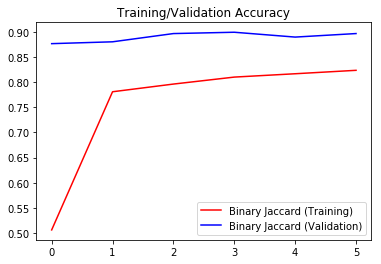

<Figure size 432x288 with 0 Axes>

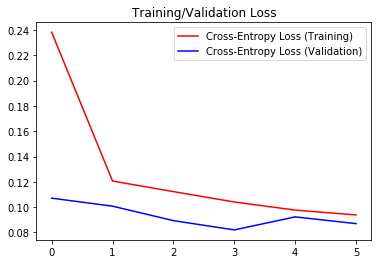

<Figure size 432x288 with 0 Axes>

In [0]:
# Avoid Pre-Allocation + Dynamically Grow GPU RAM by TensorFlow
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8
config.gpu_options.allow_growth = True
session = tf.Session(config=config)


if __name__ == '__main__':

    # Master Parameters    
    model_weights = None                  # Model Weights(For Evaluation)
    task_idx = 1                          # Task Number
    version = '100'                       # Execution Number
    

    # Encoder Parameters
    backbone_name = 'densenet201'         # Encoder Backbone
    enc_weights = 'imagenet'              # Pre-Trained Encoder Weights('imagenet'/None)
    encoder_activation = 'relu'           # Activation
    enc_freeze= False                     # Freeze DenseNet Encoder Layers (3:706)


    # Decoder Parameters
    upsampling_type = 'deconv'
    bottleneck = True
    init_nb_filters = 32
    growth_rate = 2
    nb_blocks = 5
    nb_layers_per_block = 2
    max_nb_filters = 512
    decoder_activation = 'relu'
    use_activation = True
    use_soft_mask = False
    dec_freeze= False                    # Freeze Decoder Layers (706:732)


    # Training Parameters
    batch_size = 16
    initial_epoch = 0
    epochs = 6
    init_lr = 1e-4              
    min_lr = 1e-7
    patience = 2                          # Learning Rate Decay Patience
    lrDecay = 0.50                        # Learning Rate Decay


    # Data Augmentation (Spatial+Color) Parameters
    use_data_aug = True
    colorAug_add = 'X'                    # Using Additional Color Augmented Dataset ('X'/'01'/'02'/'03')
    colorAug_online = False               # Using Online Color Augmentation
    color_space = False                   # Define Color Space (False/'HSV'/'LAB'/'HSV_LAB')
    horizontal_flip = True
    vertical_flip = True
    rotation_angle = 180
    width_shift_range = 0.1
    height_shift_range = 0.1



    # Load Training Data
    x = load_task12_training_images(output_size=224)
    y = load_task1_training_masks(output_size=224)
    
    # Load Preset Color Augmented Data
    if colorAug_add:
      x_aug01 = load_task12_colorAug_images(version=colorAug_add, output_size=224)
    
    # Convert to HSV/Lab/RGB+HSV+Lab Color Space
    if color_space:
      x = convertRGB(x,color_space)



    # File System Parameters
    model_name = 'task%d_%s' % (task_idx, backbone_name)
    run_name = 'task%d_%s_v%s' % (task_idx, backbone_name, version)
    from_run_name = None
    print_model_summary = True
    plot_model_summary = True
    debug_visualize = False
    logfile = open(get_log_filename(run_name=run_name), 'w+')
    original = sys.stdout
    sys.stdout = Tee(sys.stdout, logfile)
    assert task_idx in {1, 2}

    # Set Metrics
    if task_idx == 1:
        metrics = ['jaccard_index',
                   'pixelwise_sensitivity',
                   'pixelwise_specificity']
    else:
        metrics = ['jaccard_index0',
                   'jaccard_index1',
                   'jaccard_index2',
                   'jaccard_index3',
                   'jaccard_index4',
                   'jaccard_index5']



    # Loading Training/Validation Data    
    if colorAug_add:
      print('Loading Augmented Color Data')
      # Create Consolidated Training Set
      x_temp = np.zeros([x.shape[0]*2,x.shape[1],x.shape[2],x.shape[3]], dtype=x.dtype)
      y_temp = np.zeros([y.shape[0]*2,y.shape[1],y.shape[2]], dtype=y.dtype)

      x_temp[:2594][:][:][:] = x
      x_temp[2594:][:][:][:] = x_aug01

      y_temp[:2594][:][:][:] = y
      y_temp[2594:][:][:][:] = y

      print('Loading Training Data')
      x_train = x_temp
      y_train = y_temp
      x_valid = x_temp[:260][:][:]
      y_valid = y_temp[:260][:][:]
      print('Complete')
    
    else:
      x_train = x
      x_valid = x
      y_train = y
      y_valid = y



    # Format Ground Truth to Feed Segmentation Network
    if len(y_train.shape) == 3:
        y_train = y_train[..., None]
        y_valid = y_valid[..., None]
    if y_train[0].max() > 1:
        if use_soft_mask:
            y_train = y_train / 255.
            y_valid = y_valid / 255.
        else:
            y_train = (y_train > 127.5).astype(np.uint8)
            y_valid = (y_valid > 127.5).astype(np.uint8)
    else:
        y_train = y_train.astype(np.uint8)
        y_valid = y_valid.astype(np.uint8)
    n_samples_train = x_train.shape[0]
    n_samples_valid = x_valid.shape[0]



    # Segmentation Callback (ReduceLRonPlateau)    
    callbacks = config_seg_callbacks(run_name=run_name, factor=1.0-lrDecay, patience=patience, min_lr=min_lr, mode='auto')

    print('Loading Neural Network Model')
    # Model Definition
    model = denseU_seg  (enc_freeze=enc_freeze,
                         dec_freeze=dec_freeze,
                         enc_weights=enc_weights,
                         model_weights=model_weights,
                         input_shape=x_train.shape[1:],
                         num_classes=y_train.shape[3],
                         upsampling_type=upsampling_type,
                         bottleneck=bottleneck,
                         init_nb_filters=init_nb_filters,
                         growth_rate=growth_rate,
                         nb_layers_per_block=nb_layers_per_block,
                         max_nb_filters=max_nb_filters,
                         activation=decoder_activation,
                         use_activation=use_activation,
                         save_to=run_name,
                         print_model_summary=print_model_summary,
                         plot_model_summary=plot_model_summary,
                         lr=init_lr,
                         loss='ce',
                         metrics=metrics,
                         name=model_name)




    # Display/Log Variables
    log_variable(var_name='n_samples_train', var_value=n_samples_train)
    log_variable(var_name='n_samples_valid', var_value=n_samples_valid)
    log_variable(var_name='enc_freeze', var_value=enc_freeze)
    log_variable(var_name='dec_freeze', var_value=dec_freeze)
    log_variable(var_name='lrDecay', var_value=lrDecay)
    log_variable(var_name='input_shape', var_value=x_train.shape[1:])
    log_variable(var_name='num_classes', var_value=y_train.shape[3])
    log_variable(var_name='upsampling_type', var_value=upsampling_type)
    log_variable(var_name='bottleneck', var_value=bottleneck)
    log_variable(var_name='init_nb_filters', var_value=init_nb_filters)
    log_variable(var_name='growth_rate', var_value=growth_rate)
    log_variable(var_name='nb_layers_per_block', var_value=nb_layers_per_block)
    log_variable(var_name='max_nb_filters', var_value=max_nb_filters)
    log_variable(var_name='encoder_activation', var_value=encoder_activation)
    log_variable(var_name='decoder_activation', var_value=decoder_activation)
    log_variable(var_name='use_activation', var_value=use_activation)
    log_variable(var_name='use_soft_mask', var_value=use_soft_mask)
    log_variable(var_name='batch_size', var_value=batch_size)
    log_variable(var_name='initial_epoch', var_value=initial_epoch)
    log_variable(var_name='epochs', var_value=epochs)
    log_variable(var_name='init_lr', var_value=init_lr)
    log_variable(var_name='min_lr', var_value=min_lr)
    log_variable(var_name='patience', var_value=patience)
    log_variable(var_name='use_data_aug', var_value=use_data_aug)

    if use_data_aug:
        log_variable(var_name='colorAug_add', var_value=colorAug_add)
        log_variable(var_name='colorAug_online', var_value=colorAug_online)
        log_variable(var_name='horizontal_flip', var_value=horizontal_flip)
        log_variable(var_name='vertical_flip', var_value=vertical_flip)
        log_variable(var_name='width_shift_range', var_value=width_shift_range)
        log_variable(var_name='height_shift_range', var_value=height_shift_range)
        log_variable(var_name='rotation_angle', var_value=rotation_angle)
    sys.stdout.flush()





    # Colour + Spatial Augmentation (via CustomImageDataGenerator)
    if use_data_aug:

        aug_seed = 42

        colorspatialAug_args = dict(colorAugmentation=colorAug_online,
                                    horizontal_flip=horizontal_flip,
                                    vertical_flip=vertical_flip,
                                    rotation_range=rotation_angle,
                                    width_shift_range=width_shift_range,
                                    height_shift_range=height_shift_range)

        spatialAug_args = dict(colorAugmentation=False,
                               horizontal_flip=horizontal_flip,
                               vertical_flip=vertical_flip,
                               rotation_range=rotation_angle,
                               width_shift_range=width_shift_range,
                               height_shift_range=height_shift_range)

        colorspatialAug_images = CheesecakeImageDataGenerator(**colorspatialAug_args)
        spatialAug_masks = CheesecakeImageDataGenerator(**spatialAug_args)

        colorspatialAug_images.fit(x_train, augment=True, seed=aug_seed)
        spatialAug_masks.fit(y_train, augment=True, seed=aug_seed)

        image_generator = colorspatialAug_images.flow(x=x_train, batch_size=batch_size, seed=aug_seed)
        mask_generator = spatialAug_masks.flow(x=y_train, batch_size=batch_size, seed=aug_seed)

        train_generator = zip(image_generator, mask_generator)

        # Train Model
        print('Training...')
        history = model.fit_generator(generator=train_generator,
                                      steps_per_epoch=n_samples_train // batch_size,
                                      epochs=epochs,
                                      initial_epoch=initial_epoch,
                                      verbose=1,
                                      validation_data=(x_valid, y_valid),
                                      callbacks=callbacks,
                                      workers=8,
                                      use_multiprocessing=False)
    else:
        history = model.fit(x=x_train,
                            y=y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=(x_valid, y_valid),
                            shuffle=True,
                            callbacks=callbacks)
    sys.stdout = original


    print('Complete')


    # Plot Statistics
    acc = history.history['binary_jaccard_index']
    val_acc = history.history['val_binary_jaccard_index']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Binary Jaccard (Training)')
    plt.plot(epochs, val_acc, 'b', label='Binary Jaccard (Validation)')
    plt.title('Training/Validation Accuracy')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

    plt.plot(epochs, loss, 'r', label='Cross-Entropy Loss (Training)')
    plt.plot(epochs, val_loss, 'b', label='Cross-Entropy Loss (Validation)')
    plt.title('Training/Validation Loss')
    plt.legend(loc=0)
    plt.figure()

    plt.show()

session.close()


# ● Debugger (Layer Training Status)

## Encoder Layers (707)

In [0]:
import keras
from keras.applications import densenet as keras_densenet

indices = slice(0, 2)
input_shape = [224,224,3]
inputs = keras.layers.Input(shape=input_shape)
output_size = input_shape[indices]
encoder_in = inputs
     

# Build Pre-Trained Encoder
encoder_in = keras.layers.Lambda(lambda x: keras_densenet.preprocess_input(x))(encoder_in)
densenet = keras_densenet.DenseNet201(include_top=False,
                                      input_tensor=encoder_in,
                                      weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.
74842112/74836368 [==============================] - 1s 0us/step


In [0]:
for layer in densenet.layers:
    print(layer, layer.trainable) 

<keras.engine.input_layer.InputLayer object at 0x7f5d0d01e780> False
<keras.layers.core.Lambda object at 0x7f5d0d01e080> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5d0d01e518> True
<keras.layers.convolutional.Conv2D object at 0x7f5d0c25f550> True
<keras.layers.normalization.BatchNormalization object at 0x7f5d0d04fd30> True
<keras.layers.core.Activation object at 0x7f5d0d04f9b0> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f5d0c1b0b00> True
<keras.layers.pooling.MaxPooling2D object at 0x7f5d0a171c50> True
<keras.layers.normalization.BatchNormalization object at 0x7f5d0cffd9e8> True
<keras.layers.core.Activation object at 0x7f5d0a15ecc0> True
<keras.layers.convolutional.Conv2D object at 0x7f5d0a107b00> True
<keras.layers.normalization.BatchNormalization object at 0x7f5d0a0d66d8> True
<keras.layers.core.Activation object at 0x7f5d0a087b38> True
<keras.layers.convolutional.Conv2D object at 0x7f5d09fc0f98> True
<keras.layers.merge.Concatenate object at 0x7f5

## Decoder Layers (25 )

In [0]:
backbone_name = 'densenet201'       # Encoder Backbone
preweights = None                   # Pre-Trained Encoder Weights
task_idx = 1                        # Task Number
version = '2'                       # Execution Number
num_splits = 2                      # Number of Data Splits
k_split = 0

x = load_task12_training_images(output_size=224)
y = load_task1_training_masks(output_size=224)

# Decoder Parameters
upsampling_type = 'deconv'
bottleneck = True
batch_normalization = False
init_nb_filters = 32
growth_rate = 2
nb_blocks = 5
nb_layers_per_block = 2
max_nb_filters = 512
encoder_activation = 'relu'
decoder_activation = 'relu'
use_activation = True
use_soft_mask = False

backbone_options = {}

# Training Parameters
batch_size = 14
initial_epoch = 0
epochs = 50
init_lr = 1e-4              
min_lr = 1e-7
patience = 1

# Data Augmentation Parameters
use_data_aug = True
horizontal_flip = True
vertical_flip = True
rotation_angle = 45
width_shift_range = 0.1
height_shift_range = 0.1

# File System Parameters
model_name = 'task%d_%s' % (task_idx, backbone_name)
run_name = 'task%d_%s_k%d_v%s' % (task_idx, backbone_name, k_split, version)
from_run_name = None
debug = False
print_model_summary = True
plot_model_summary = True
debug_visualize = False

assert task_idx in {1, 2}

# Set Metrics
if task_idx == 1:
    metrics = ['jaccard_index',
               'pixelwise_sensitivity',
               'pixelwise_specificity']
else:
    metrics = ['jaccard_index0',
               'jaccard_index1',
               'jaccard_index2',
               'jaccard_index3',
               'jaccard_index4',
               'jaccard_index5']

 # K-Split Random Subsampling Cross Validation    
seed = (k_split+1) * num_splits              # 5 10 15 20 25    
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=seed)

# Assert Input Shapes + Feed to Segmentation Network
if len(y_train.shape) == 3:
    y_train = y_train[..., None]
    y_valid = y_valid[..., None]
if y_train[0].max() > 1:
    if use_soft_mask:
        y_train = y_train / 255.
        y_valid = y_valid / 255.
    else:
        y_train = (y_train > 127.5).astype(np.uint8)
        y_valid = (y_valid > 127.5).astype(np.uint8)
else:
    y_train = y_train.astype(np.uint8)
    y_valid = y_valid.astype(np.uint8)
n_samples_train = x_train.shape[0]
n_samples_valid = x_valid.shape[0]

callbacks = config_seg_callbacks(run_name)


In [0]:
num_classes = y_train.shape[3]
backbone_layer_names = ['conv2_block6_concat',
                        'conv3_block12_concat',
                        'conv4_block48_concat',
                        'conv5_block32_concat']
backbone_layers = [densenet.get_layer(name=layer_name) for layer_name in backbone_layer_names]
backbone_features = [backbone_layer.output for backbone_layer in backbone_layers]



# Build Decoder
outputs = default_decoder_model(features=backbone_features,
                                num_classes=num_classes,
                                output_size=output_size,
                                scale_factor=2,
                                init_nb_filters=init_nb_filters,
                                growth_rate=growth_rate,
                                nb_layers_per_block=nb_layers_per_block,
                                max_nb_filters=max_nb_filters,
                                upsampling_type=upsampling_type,
                                bottleneck=bottleneck,
                                activation=decoder_activation,
                                use_activation=use_activation,
                                include_top=False)

outputs = keras.layers.Conv2D(num_classes, (1, 1), activation='linear', name='predictions')(outputs)
output_activation = 'sigmoid' if num_classes == 1 else 'softmax'
outputs = keras.layers.Activation(output_activation, name='outputs')(outputs)
     

# Build Complete Model
model = keras.models.Model(inputs=inputs, outputs=outputs)

In [0]:
for layer in model.layers[706:]:
    print(layer, layer.trainable) 

<keras.layers.convolutional.Conv2D object at 0x7f5cfafa3198> True
<keras.layers.convolutional.Conv2DTranspose object at 0x7f5cfb483588> True
<keras.layers.convolutional.Conv2D object at 0x7f5cfb0020f0> True
<keras.layers.merge.Concatenate object at 0x7f5d0d05c630> True
<keras.layers.convolutional.Conv2D object at 0x7f5d0d05c320> True
<keras.layers.core.Activation object at 0x7f5cfb85fd68> True
<keras.layers.convolutional.Conv2D object at 0x7f5cfb920d68> True
<keras.layers.core.Activation object at 0x7f5cfba2bd68> True
<keras.layers.convolutional.Conv2DTranspose object at 0x7f5cfb871a90> True
<keras.layers.convolutional.Conv2D object at 0x7f5cfb126320> True
<keras.layers.merge.Concatenate object at 0x7f5cfbbe6da0> True
<keras.layers.convolutional.Conv2D object at 0x7f5cfbbac588> True
<keras.layers.core.Activation object at 0x7f5cfae4a908> True
<keras.layers.convolutional.Conv2D object at 0x7f5cfae4acf8> True
<keras.layers.core.Activation object at 0x7f5cfad07080> True
<keras.layers.conv

# ● Debugger (Augmentation)

## Online Augmentation

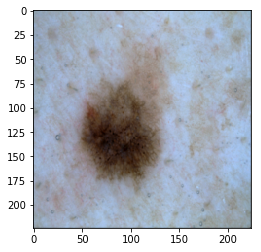

In [0]:
W = WhiteBalance(x_train[0])
C = ColorCast(W)

#plt.imshow(x_train[0])
#plt.imshow(W)
#plt.imshow(C)
#x_train[0].max()
#C[:][:][2].max()

In [0]:
# Avoid Pre-Allocation + Dynamically Grow GPU RAM by TensorFlow
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Data Augmentation (Spatial) Parameters
use_data_aug = True
horizontal_flip = True
vertical_flip = True
rotation_angle = 180
width_shift_range = 0.1
height_shift_range = 0.1


# Load Training Data
x = load_task12_training_images(output_size=224)
y = load_task1_training_masks(output_size=224)


# K-Split Random Subsampling Cross Validation    
split_seed = 5    
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=split_seed)

# Modify Ground Truth Format to Feed Segmentation Network
if len(y_train.shape) == 3:
    y_train = y_train[..., None]
    y_valid = y_valid[..., None]
if y_train[0].max() > 1:
    y_train = (y_train > 127.5).astype(np.uint8)
    y_valid = (y_valid > 127.5).astype(np.uint8)
else:
    y_train = y_train.astype(np.uint8)
    y_valid = y_valid.astype(np.uint8)
n_samples_train = x_train.shape[0]

In [0]:
aug_seed = 42

colorspatialAug_args = dict(colorAugmentation=True,
                            horizontal_flip=True,
                            vertical_flip=True,
                            rotation_range=180,
                            width_shift_range=0.1,
                            height_shift_range=0.1)

spatialAug_args = dict(colorAugmentation=False,
                       horizontal_flip=True,
                       vertical_flip=True,
                       rotation_range=180,
                       width_shift_range=0.1,
                       height_shift_range=0.1)

colorspatialAug_images = CheesecakeImageDataGenerator(**colorspatialAug_args)
spatialAug_masks = CheesecakeImageDataGenerator(**spatialAug_args)

colorspatialAug_images.fit(x_train, augment=True, seed=aug_seed)
spatialAug_masks.fit(y_train, augment=True, seed=aug_seed)

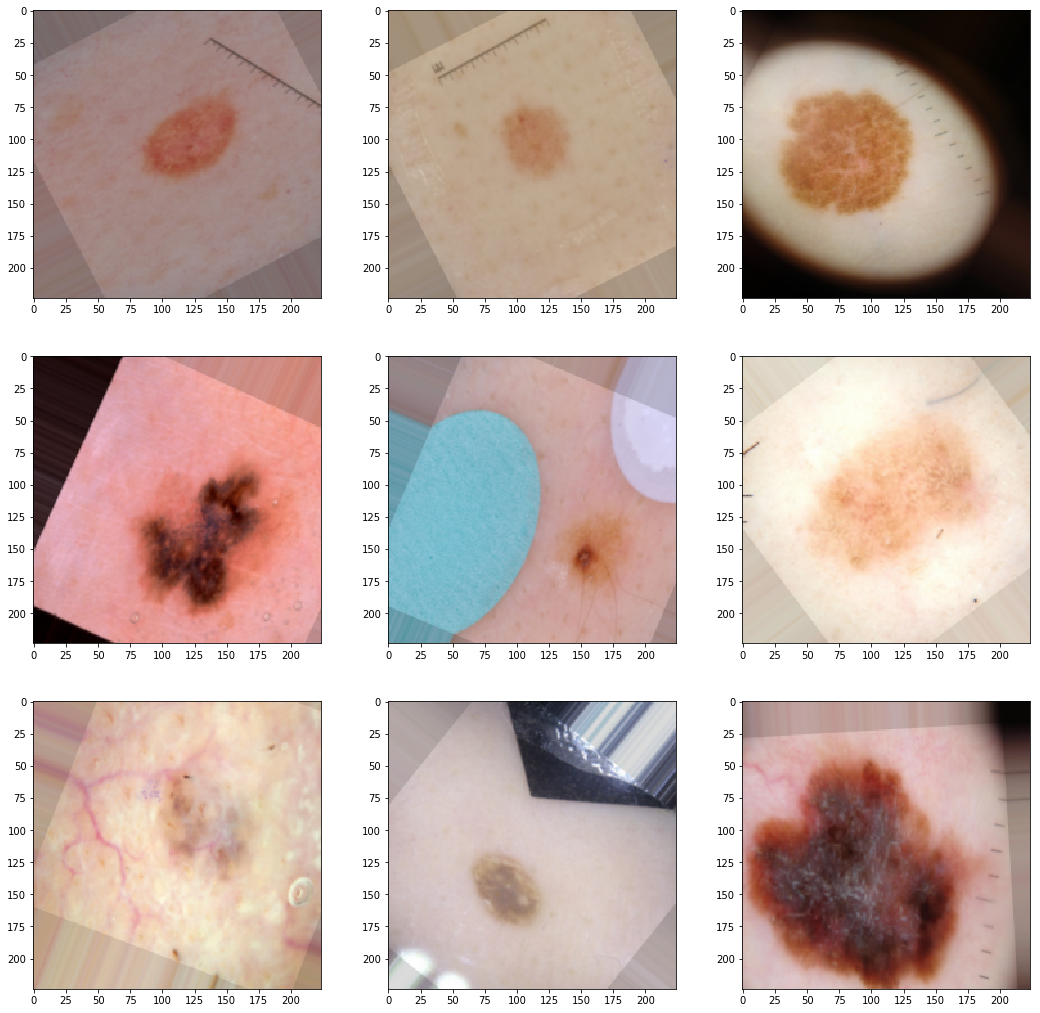

In [0]:
from matplotlib import pyplot

plt.figure(figsize=(18,18))
for x_batch in colorspatialAug_images.flow(x_train, batch_size=9, seed=aug_seed):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].astype(np.uint8))
    plt.show()
    break

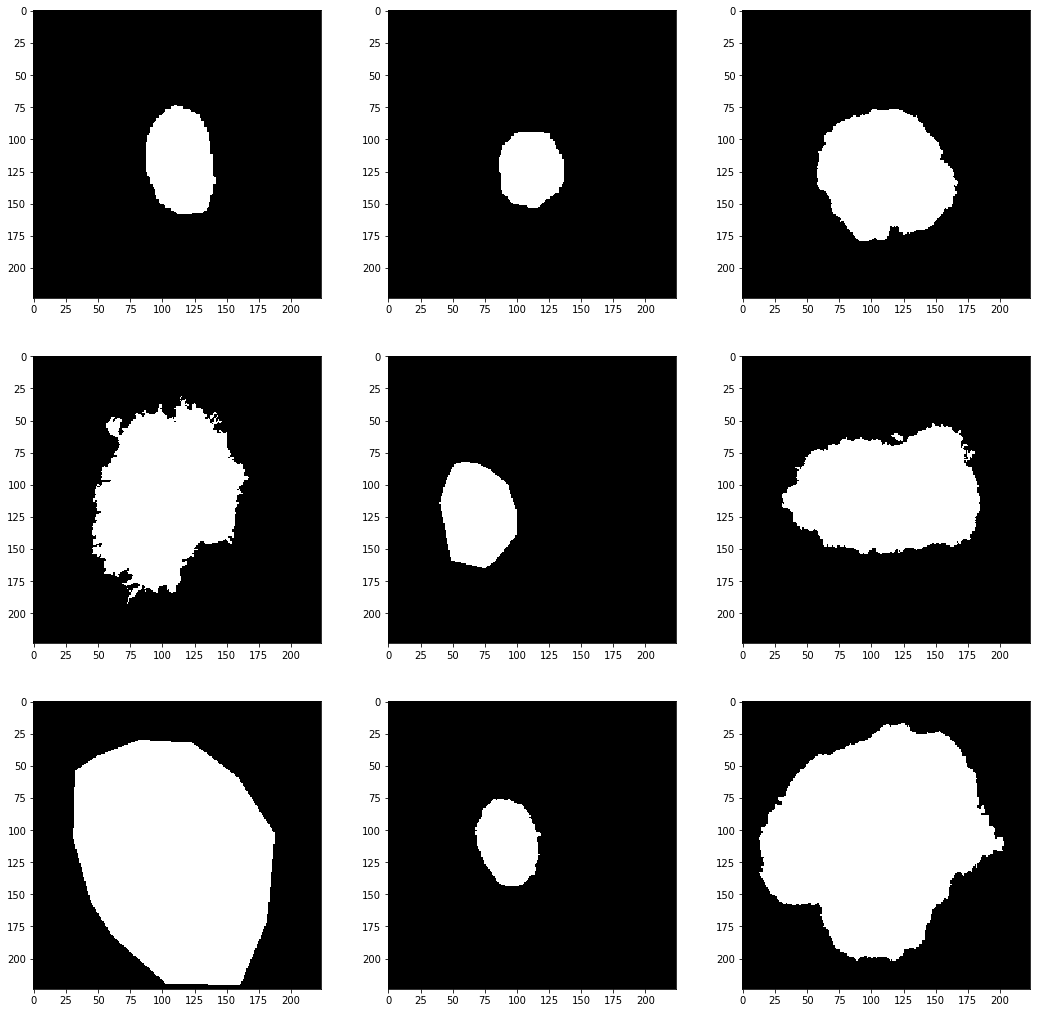

In [0]:
from matplotlib import pyplot

plt.figure(figsize=(18,18))
for x_batch in spatialAug_masks.flow(x=y_train, batch_size=9, seed=aug_seed):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].squeeze(),cmap='gray')
    plt.show()
    break

In [0]:
np.random.randint(2)

array([1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0])

## Additional Augmentated Set

In [0]:
# Avoid Pre-Allocation + Dynamically Grow GPU RAM by TensorFlow
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

# Load Training Data
x = load_task12_training_images(output_size=224)
y = load_task1_training_masks(output_size=224)

# Load Color Augmentation Data
x_aug01 = load_task12_colorAug01_images(output_size=224)

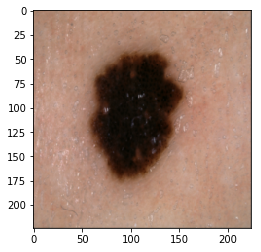

In [0]:
plt.imshow(x_aug01[2334])

In [0]:
# K-Split Random Subsampling Cross Validation    
split_seed = 5    
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1, random_state=split_seed)

x_aug01_train,_,_,_ = train_test_split(x_aug01, y, test_size=0.1, random_state=split_seed)

(2334, 224, 224, 3)


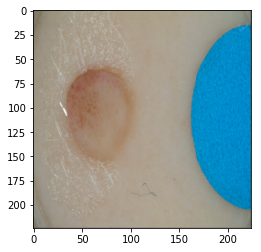

In [0]:
plt.imshow(x_train[9])
print(x_train.shape)

In [0]:
x_temp = np.zeros([x_train.shape[0]*2,x_train.shape[1],x_train.shape[2],x_train.shape[3]], dtype=x_train.dtype)
y_temp = np.zeros([y_train.shape[0]*2,y_train.shape[1],y_train.shape[2]], dtype=y_train.dtype)
x_temp.shape

(4668, 224, 224, 3)

In [0]:
x_temp[:2334][:][:][:] = x_train
x_temp[2334:][:][:][:] = x_aug01_train

y_temp[:2334][:][:][:] = y_train
y_temp[2334:][:][:][:] = y_train

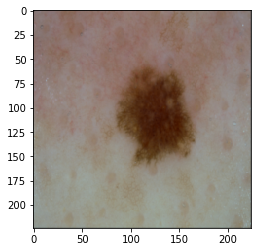

In [0]:
plt.imshow(x_temp[2333+2334])

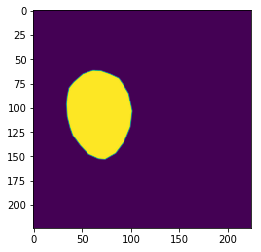

In [0]:
plt.imshow(y_temp[9+2334])

## Color Space

In [0]:
# Load Training Data
x = load_task12_training_images(output_size=224)
y = load_task1_training_masks(output_size=224)

In [0]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10, (1,1), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(3, (1,1), activation='relu'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [0]:
x_HSV = convertRGB(x,'HSV')

In [0]:
x_HSV[:,:,:,2].mean()

180.41729756592184

In [0]:
x_train.shape[1:]

(224, 224, 9)

In [0]:
version = '01'
output_size = 224
dataset = '/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/colorAug/task12_colorAug' + version + '_%d.npy' % (output_size)

In [0]:
dataset

'/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/datasets/ISIC2018/cache/colorAug/task12_colorAug01_224.npy'

# ● Visualizing Feature Maps

In [0]:
# Master Parameters
backbone_name = 'densenet201'
model_weights = 'XF1.hdf5'
enc_weights = None
version = '0'
task_idx = 1


# Test Data Definition
images, image_sizes = load_task12_test_images(output_size=224)
image_names = task12_test_image_ids

max_num_images = images.shape[0]
images = images[:max_num_images]
image_names = image_names[:max_num_images]
image_sizes = image_sizes[:max_num_images]
y_pred = np.zeros(shape=(max_num_images, 224, 224))

model_name = 'task%d_%s' % (task_idx, backbone_name)


# Model Data Definition
x = load_task12_training_images(output_size=224)
y = load_task1_training_masks(output_size=224)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.1)


if len(y_train.shape) == 3:
    y_train = y_train[..., None]
    y_valid = y_valid[..., None]
if y_train[0].max() > 1:
        y_train = (y_train > 127.5).astype(np.uint8)
        y_valid = (y_valid > 127.5).astype(np.uint8)
else:
    y_train = y_train.astype(np.uint8)
    y_valid = y_valid.astype(np.uint8)



metrics = ['jaccard_index',
           'pixelwise_sensitivity',
           'pixelwise_specificity']


# Model Definition
model = denseU_seg  (enc_freeze=None,
                     dec_freeze=None,
                     enc_weights=enc_weights,
                     model_weights=model_weights,
                     input_shape=x_train.shape[1:],
                     num_classes=y_train.shape[3],
                     upsampling_type='deconv',
                     bottleneck=True,
                     init_nb_filters=32,
                     growth_rate=2,
                     nb_layers_per_block=2,
                     max_nb_filters=512,
                     activation='relu',
                     use_activation=True,
                     save_to=False,
                     print_model_summary=False,
                     plot_model_summary=False,
                     lr=1e-4,
                     loss='ce',
                     metrics=metrics,
                     name=model_name)

Instructions for updating:
Colocations handled automatically by placer.
Model Weights Successfully Loaded: XF1.hdf5


## View Feature Maps

In [0]:
import matplotlib.pyplot as plt
from tensorflow.keras import layers,models

FIRST_IMAGE   =  0
SECOND_IMAGE  =  7
THIRD_IMAGE   =  26

conv_layers = 20
start_layer = 100
filter_num = 1

f, axarr = plt.subplots(3,conv_layers,figsize=(15,5))
test_images = load_task12_test_images(output_size=224)

layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs = model.input, outputs = layer_outputs[start_layer:])

for x in range(0,conv_layers):
  f1 = activation_model.predict(test_images[0][FIRST_IMAGE].reshape(1, 224, 224, 3))[x]
  axarr[0,x].imshow(f1[0, : , :, filter_num], cmap='inferno')
  axarr[0,x].grid(False)
  
  f2 = activation_model.predict(test_images[0][SECOND_IMAGE].reshape(1, 224, 224, 3))[x]
  axarr[1,x].imshow(f2[0, : , :, filter_num], cmap='inferno')
  axarr[1,x].grid(False)
  
  f3 = activation_model.predict(test_images[0][THIRD_IMAGE].reshape(1, 224, 224, 3))[x]
  axarr[2,x].imshow(f3[0, : , :, filter_num], cmap='inferno')
  axarr[2,x].grid(False)

## Export Feature Maps

In [0]:
import numpy as np
from PIL import Image

image_id = 599
conv_layers = 729
start_layer = 1
filter_num = 1

outdir = '/content/gdrive/My Drive/skin-lesion-analysis/train01/u-net00/featuremaps1'
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs = model.input, outputs = layer_outputs[start_layer:])

for x in range(0,conv_layers):
  f1 = activation_model.predict(test_images[0][image_id].reshape(1, 224, 224, 3))[x]
  # Saving Masks
  plt.imsave(outdir + '/' + str(x) + '_featuremap.png', arr=f1[0,:,:,filter_num], cmap='inferno')

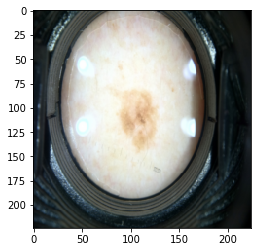

In [0]:
plt.imshow(test_images[0][599])

# ● Visualizing Features

In [0]:
from __future__ import print_function

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import vgg16
from keras import backend as K


def normalize(x):
    """utility function to normalize a tensor.
    # Arguments
        x: An input tensor.
    # Returns
        The normalized input tensor.
    """
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


def deprocess_image(x):
    """utility function to convert a float array into a valid uint8 image.
    # Arguments
        x: A numpy-array representing the generated image.
    # Returns
        A processed numpy-array, which could be used in e.g. imshow.
    """
    # normalize tensor: center on 0., ensure std is 0.25
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.25

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def process_image(x, former):
    """utility function to convert a valid uint8 image back into a float array.
       Reverses `deprocess_image`.
    # Arguments
        x: A numpy-array, which could be used in e.g. imshow.
        former: The former numpy-array.
                Need to determine the former mean and variance.
    # Returns
        A processed numpy-array representing the generated image.
    """
    if K.image_data_format() == 'channels_first':
        x = x.transpose((2, 0, 1))
    return (x / 255 - 0.5) * 4 * former.std() + former.mean()


def visualize_layer(model,
                    layer_name,
                    step=1.,
                    epochs=15,
                    upscaling_steps=9,
                    upscaling_factor=1.2,
                    output_dim=(412, 412),
                    filter_range=(0, None)):
    """Visualizes the most relevant filters of one conv-layer in a certain model.
    # Arguments
        model: The model containing layer_name.
        layer_name: The name of the layer to be visualized.
                    Has to be a part of model.
        step: step size for gradient ascent.
        epochs: Number of iterations for gradient ascent.
        upscaling_steps: Number of upscaling steps.
                         Starting image is in this case (80, 80).
        upscaling_factor: Factor to which to slowly upgrade
                          the image towards output_dim.
        output_dim: [img_width, img_height] The output image dimensions.
        filter_range: Tupel[lower, upper]
                      Determines the to be computed filter numbers.
                      If the second value is `None`,
                      the last filter will be inferred as the upper boundary.
    """

    def _generate_filter_image(input_img,
                               layer_output,
                               filter_index):
        """Generates image for one particular filter.
        # Arguments
            input_img: The input-image Tensor.
            layer_output: The output-image Tensor.
            filter_index: The to be processed filter number.
                          Assumed to be valid.
        #Returns
            Either None if no image could be generated.
            or a tuple of the image (array) itself and the last loss.
        """
        s_time = time.time()

        # we build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        if K.image_data_format() == 'channels_first':
            loss = K.mean(layer_output[:, filter_index, :, :])
        else:
            loss = K.mean(layer_output[:, :, :, filter_index])

        # we compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, input_img)[0]

        # normalization trick: we normalize the gradient
        grads = normalize(grads)

        # this function returns the loss and grads given the input picture
        iterate = K.function([input_img], [loss, grads])

        # we start from a gray image with some random noise
        intermediate_dim = tuple(
            int(x / (upscaling_factor ** upscaling_steps)) for x in output_dim)
        if K.image_data_format() == 'channels_first':
            
            #ininin = cv2.imread('meow.jpg')
            #input_img_data = [1,ininin[2],ininin[0],ininin[1]]
            input_img_data = np.random.random(
                (1, 3, intermediate_dim[0], intermediate_dim[1]))
        else:
            #ininin = cv2.imread('meow.jpg')
            #input_img_data = [1,ininin[0],ininin[1],ininin[2]]
            input_img_data = np.random.random(
                (1, intermediate_dim[0], intermediate_dim[1], 3))
        
        input_img_data = (input_img_data - 0.5) * 20 + 128

        # Slowly upscaling towards the original size prevents
        # a dominating high-frequency of the to visualized structure
        # as it would occur if we directly compute the 412d-image.
        # Behaves as a better starting point for each following dimension
        # and therefore avoids poor local minima
        for up in reversed(range(upscaling_steps)):
            # we run gradient ascent for e.g. 20 steps
            for _ in range(epochs):
                loss_value, grads_value = iterate([input_img_data])
                input_img_data += grads_value * step

                # some filters get stuck to 0, we can skip them
                if loss_value <= K.epsilon():
                    return None

            # Calulate upscaled dimension
            intermediate_dim = tuple(
                int(x / (upscaling_factor ** up)) for x in output_dim)
            # Upscale
            img = deprocess_image(input_img_data[0])
            img = np.array(pil_image.fromarray(img).resize(intermediate_dim,
                                                           pil_image.BICUBIC))
            input_img_data = [process_image(img, input_img_data[0])]

        # decode the resulting input image
        img = deprocess_image(input_img_data[0])
        e_time = time.time()
        print('Costs of filter {:3}: {:5.0f} ( {:4.2f}s )'.format(filter_index,
                                                                  loss_value,
                                                                  e_time - s_time))
        return img, loss_value

    def _draw_filters(filters, n=None):
        """Draw the best filters in a nxn grid.
        # Arguments
            filters: A List of generated images and their corresponding losses
                     for each processed filter.
            n: dimension of the grid.
               If none, the largest possible square will be used
        """
        if n is None:
            n = int(np.floor(np.sqrt(len(filters))))

        # the filters that have the highest loss are assumed to be better-looking.
        # we will only keep the top n*n filters.
        filters.sort(key=lambda x: x[1], reverse=True)
        filters = filters[:n * n]

        # build a black picture with enough space for
        # e.g. our 8 x 8 filters of size 412 x 412, with a 5px margin in between
        MARGIN = 5
        width = n * output_dim[0] + (n - 1) * MARGIN
        height = n * output_dim[1] + (n - 1) * MARGIN
        stitched_filters = np.zeros((width, height, 3), dtype='uint8')

        # fill the picture with our saved filters
        for i in range(n):
            for j in range(n):
                img, _ = filters[i * n + j]
                width_margin = (output_dim[0] + MARGIN) * i
                height_margin = (output_dim[1] + MARGIN) * j
                stitched_filters[
                    width_margin: width_margin + output_dim[0],
                    height_margin: height_margin + output_dim[1], :] = img

        # save the result to disk
        save_img('vgg_{0:}_{1:}x{1:}.png'.format(n, n), stitched_filters)

    # this is the placeholder for the input images
    assert len(model.inputs) == 1
    input_img = model.inputs[0]

    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    output_layer = layer_dict[layer_name]
    assert isinstance(output_layer, layers.Conv2D)

    # Compute to be processed filter range
    filter_lower = filter_range[0]
    filter_upper = (filter_range[1]
                    if filter_range[1] is not None
                    else output_layer.get_weights()[0].shape[3])
    assert(filter_lower >= 0
           and filter_upper <= output_layer.get_weights()[0].shape[3]
           and filter_upper > filter_lower)
    print('Compute filters {:} to {:}'.format(filter_lower, filter_upper))

    
    #filter_upper = 20
    
    # iterate through each filter and generate its corresponding image
    processed_filters = []
    for f in range(filter_lower, 60):
        img_loss = _generate_filter_image(input_img, output_layer.output, f)

        if img_loss is not None:
            processed_filters.append(img_loss)

    print('{} filter processed.'.format(len(processed_filters)))
    # Finally draw and store the best filters to disk
    _draw_filters(processed_filters)


In [0]:
layer_name = 'feature4_bottleneck'
visualize_layer(model, layer_name)

Compute filters 0 to 512
Costs of filter   0:    17 ( 60.02s )
Costs of filter   1:    12 ( 61.20s )
Costs of filter   4:     8 ( 73.00s )
Costs of filter   5:     8 ( 76.63s )
Costs of filter   6:    26 ( 80.34s )
Costs of filter   7:    31 ( 83.59s )
Costs of filter   8:    14 ( 84.56s )
Costs of filter  11:    13 ( 96.01s )
Costs of filter  12:     9 ( 102.13s )
Costs of filter  15:    26 ( 111.54s )
Costs of filter  18:    20 ( 126.62s )
Costs of filter  20:    17 ( 143.25s )
Costs of filter  21:     6 ( 138.79s )
Costs of filter  22:     4 ( 149.86s )
Costs of filter  24:    10 ( 160.59s )
Costs of filter  25:    10 ( 161.16s )
Costs of filter  26:     3 ( 173.48s )
Costs of filter  31:     4 ( 197.92s )
Costs of filter  32:    26 ( 211.15s )
Costs of filter  34:     5 ( 212.44s )
Costs of filter  35:    29 ( 223.53s )
Costs of filter  37:    23 ( 231.06s )
Costs of filter  41:    22 ( 258.44s )
Costs of filter  42:    21 ( 265.26s )
Costs of filter  48:    26 ( 323.44s )
Costs of

In [0]:
conv5_block32_2_conv
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
layer_dict

{'activation_1': <keras.layers.core.Activation at 0x7fe23b49d550>,
 'activation_2': <keras.layers.core.Activation at 0x7fe23b59e828>,
 'activation_3': <keras.layers.core.Activation at 0x7fe23b3b0518>,
 'activation_4': <keras.layers.core.Activation at 0x7fe23b3c37b8>,
 'activation_5': <keras.layers.core.Activation at 0x7fe23b3454a8>,
 'activation_6': <keras.layers.core.Activation at 0x7fe23b35a748>,
 'activation_7': <keras.layers.core.Activation at 0x7fe23b2db278>,
 'conv1/bn': <keras.layers.normalization.BatchNormalization at 0x7fe24b20c668>,
 'conv1/conv': <keras.layers.convolutional.Conv2D at 0x7fe24b1eb3c8>,
 'conv1/relu': <keras.layers.core.Activation at 0x7fe24b20cc88>,
 'conv2_block1_0_bn': <keras.layers.normalization.BatchNormalization at 0x7fe24b20cac8>,
 'conv2_block1_0_relu': <keras.layers.core.Activation at 0x7fe24890cf60>,
 'conv2_block1_1_bn': <keras.layers.normalization.BatchNormalization at 0x7fe24882f358>,
 'conv2_block1_1_conv': <keras.layers.convolutional.Conv2D at 0x

In [0]:
output_layer = layer_dict[layer_name]
output_layer.get_weights()[0].shape[3]

64

In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [0]:
input_img_data = plt.imread('meow.jpg')
input_img_data.shape

(1338, 1338, 3)